In [1]:
!pip install opendatasets --upgrade
!pip install imageio

In [1]:
import os
os.getcwd()

os.chdir('/teamspace/studios/this_studio/birdClassification/')

In [2]:
import torch
import pandas as pd
import numpy as np
import imageio as iio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from dataFunctions import *
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
from tqdm import tqdm
import os
import torchvision
%load_ext autoreload

%autoreload 2

Matplotlib created a temporary cache directory at /tmp/matplotlib-6r18pi_i because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Load in Kaggle Bird Dataset

In [10]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/gpiosenka/100-bird-species'
od.download(dataset_url)

Skipping, found downloaded files in "./100-bird-species" (use force=True to force download)


In [3]:
df = pd.read_csv('test_info.csv')
labels = list(df['labels'].unique())

# Data Pre-Processing

In [4]:
# Create Custom Pytorch Dataset to load in samples

train_images = BirdImageDataset('train_info.csv', True)
val_images = BirdImageDataset('valid_info.csv', False)
test_image = BirdImageDataset('test_info.csv', True)

In [5]:
# Initialise DataLoaders for training, testing and validation

train_loader = DataLoader(train_images, batch_size = 128, shuffle= True, num_workers = 7)
val_loader = DataLoader(val_images, batch_size = 128, shuffle = False, num_workers = 7)
test_loader = DataLoader(test_image, batch_size = 128, shuffle= False, num_workers = 7)

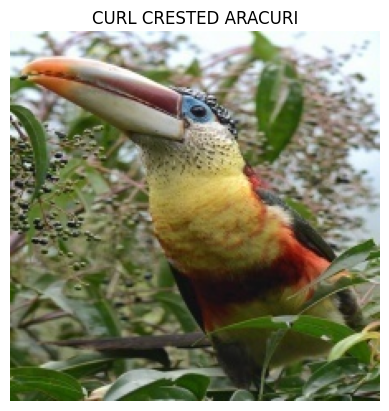

In [6]:
idx = 900
image = val_images.__get__unprocessed_item__(idx)[0]

# Convert the tensor to a PIL Image
tensor_to_pil = transforms.ToPILImage()
pil_image = tensor_to_pil(image)

# Display the image using Matplotlib

plt.title(labels[torch.where(val_images.__get__unprocessed_item__(idx)[1] == 1)[0].item()])
plt.imshow(pil_image)
plt.axis('off')  # Hide axes
plt.show()

# Initialise Model


In [7]:
#Definition of hyperparameters
n_iters = 4500
num_epochs = 10

# Load in Pre-trained Resnet Model
model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1')
model_requires_grad_params = []
# Disable Gradients in Resnet layers as we don't want to backward propagate for optimising weights
for param in model.parameters():
    param.requires_grad = False

# Feed-forward network to switch with last layer in ResNet
class FFClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop(x)
        x = self.fc1(x)

        # x = F.log_softmax(x, dim=1)
        return x

# Swap out original fc in ResNet with custom layer to match desired classifier outputs
model.fc = FFClassifier(in_features=512, out_features=525)

print(model)

# Cross Entropy Loss
l = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Device :)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Load in Pre-Trained Transfer Learned Model
model.load_state_dict(torch.load('resnet18_model.pth'))

<All keys matched successfully>

# Initialise Training Loop

In [9]:
import lightning as L

# PyTorch Lightning Model Class
class LitResnet(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model 

    def calc_batch_precision(self, pred_batch, labels_batch):
        _, preds = torch.max(pred_batch, dim=1)
        _, labels = torch.max(labels_batch, dim=1)
        return torch.tensor(torch.sum(preds == labels.to(device)).item() / len(preds))
    
    def training_step(self, batch, batch_idx):
        x, y = batch 

        output = model(x.to(device))
        l = nn.CrossEntropyLoss()
        loss = l(output, y.to(device))
        self.log("train_loss", loss, prog_bar = True)
        return loss 

    def predict_step(self, batch, batch_idx):
        x, y = batch

        pred = self.model(x.to(device))
        return pred, y

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch 

        output = model(x.to(device))
        l = nn.CrossEntropyLoss()
        loss = l(output, y.to(device))
        self.log("val_loss", loss, prog_bar = True)


    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch 

        output = model(x.to(device))
        
        precision = self.calc_batch_precision(output, y)

        self.log("test accuracy", precision, prog_bar = True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr = 1e-3)
        return optimizer


In [10]:
lighting_resnet = LitResnet(model.to(device))
trainer = L.Trainer(max_epochs= 10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [54]:
# train model
trainer.fit(model=lighting_resnet, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.4 M
---------------------------------
269 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.783    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [17]:
trainer.test(lighting_resnet, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test accuracy       │    0.9085714221000671     │
└───────────────────────────┴───────────────────────────┘

[{'test accuracy': 0.9085714221000671}]

Test accuracy of 90%, with some finetuning this could most likely hit 95+%!

# Example Inference and Visualisation

In [11]:
predictions, y = lighting_resnet.predict_step(next(iter(test_loader)), 0)

In [12]:
predicted_birds = [labels[x] for x in list(np.array(torch.max(predictions, dim = 1)[1].cpu()))]
actual_birds = [labels[x] for x in list(np.array(torch.max(y, dim = 1)[1].cpu()))]

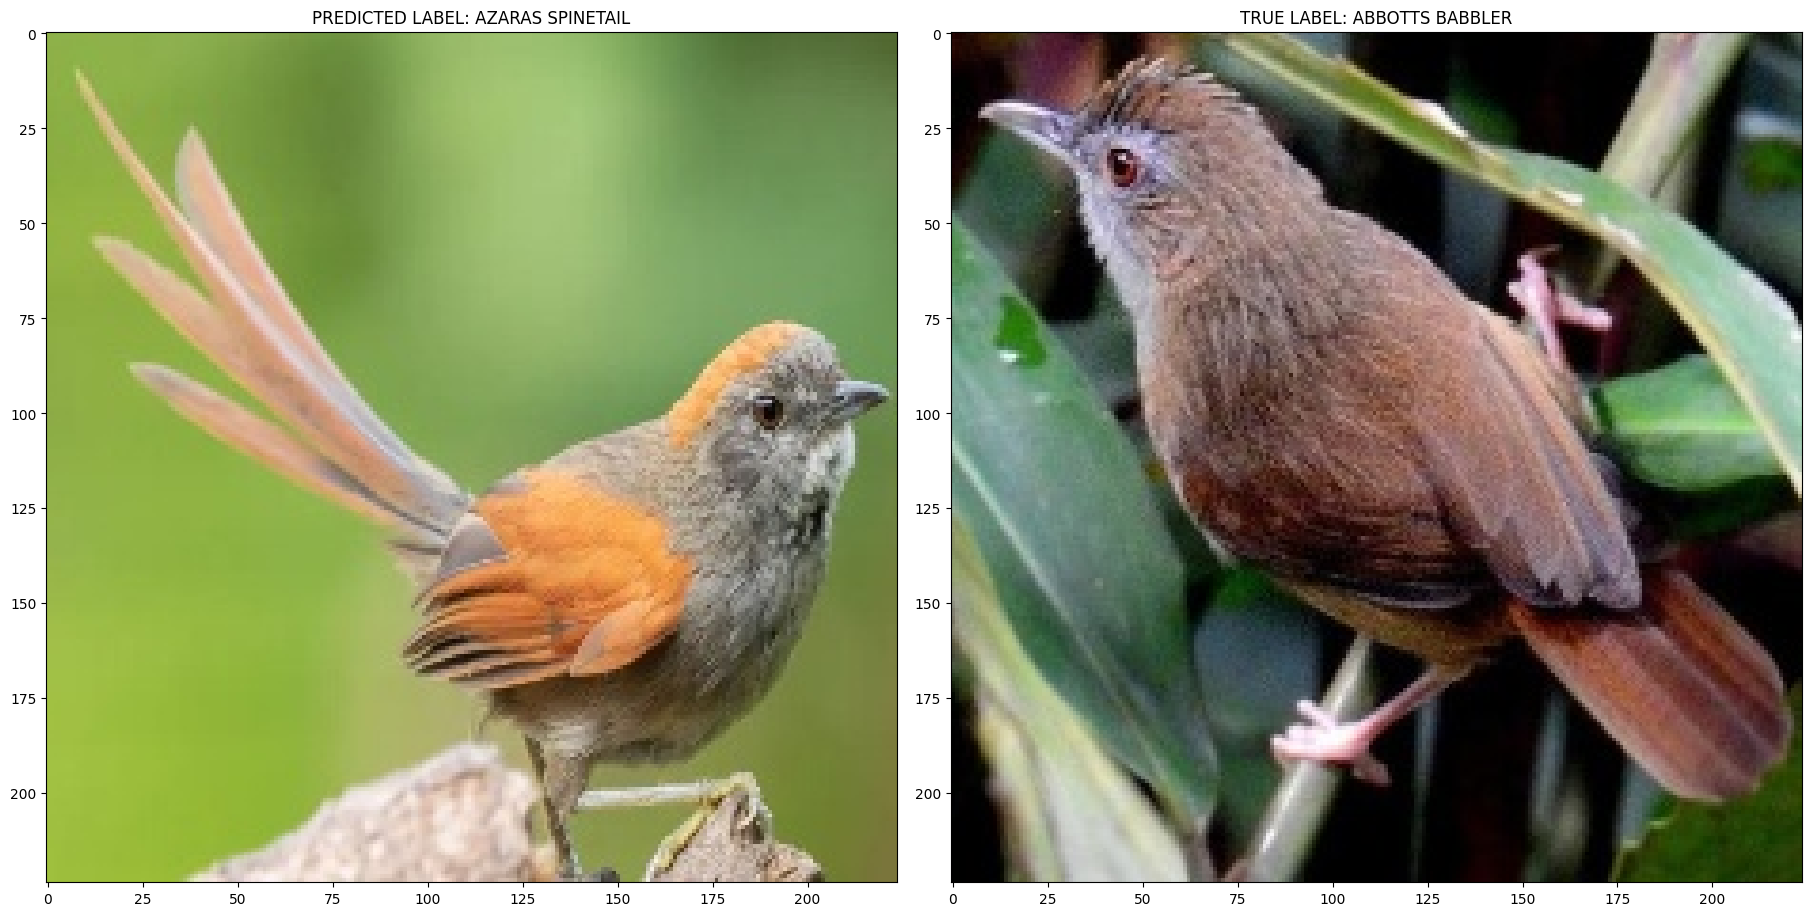

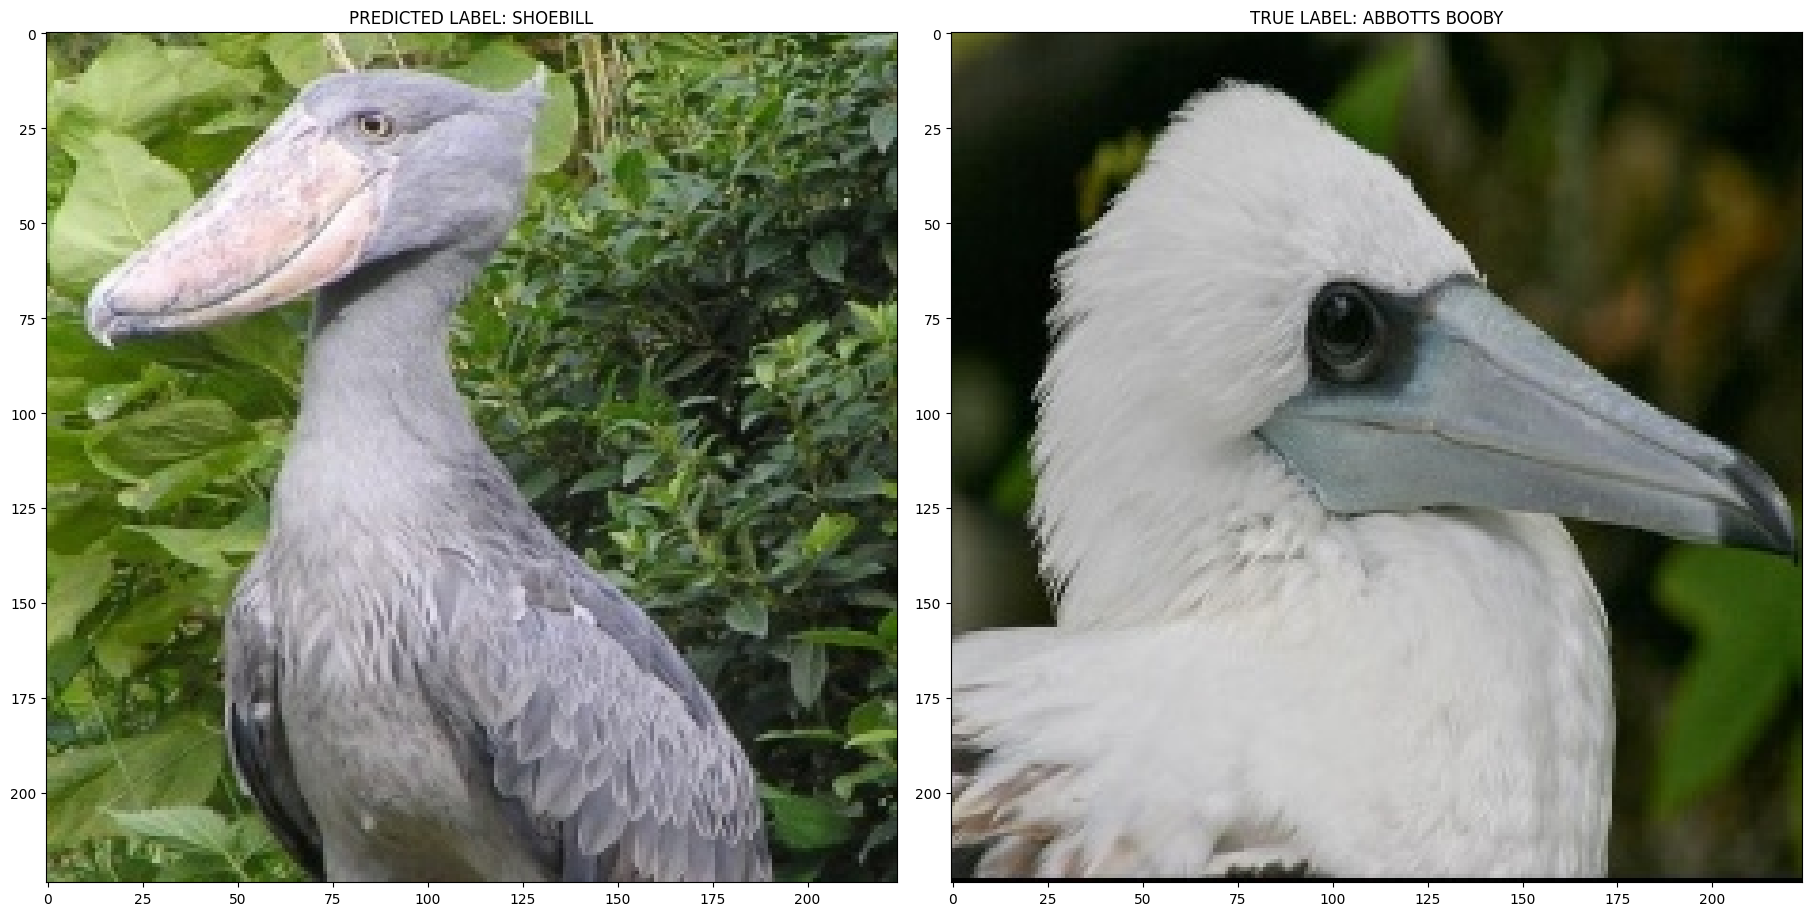

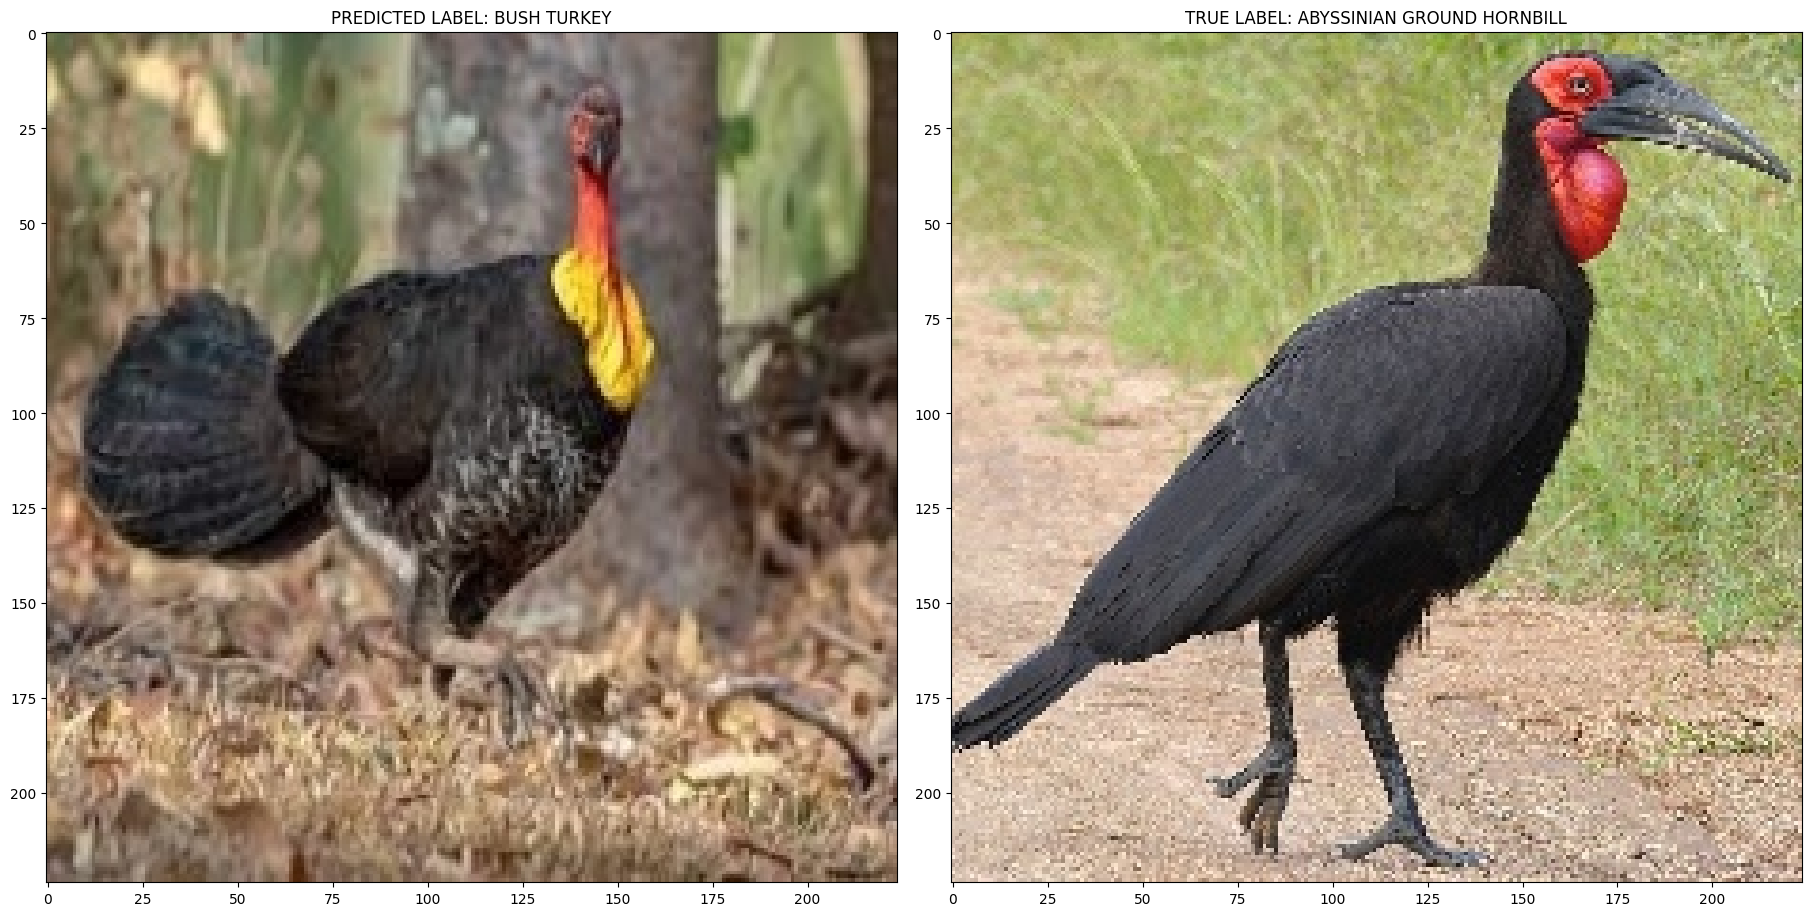

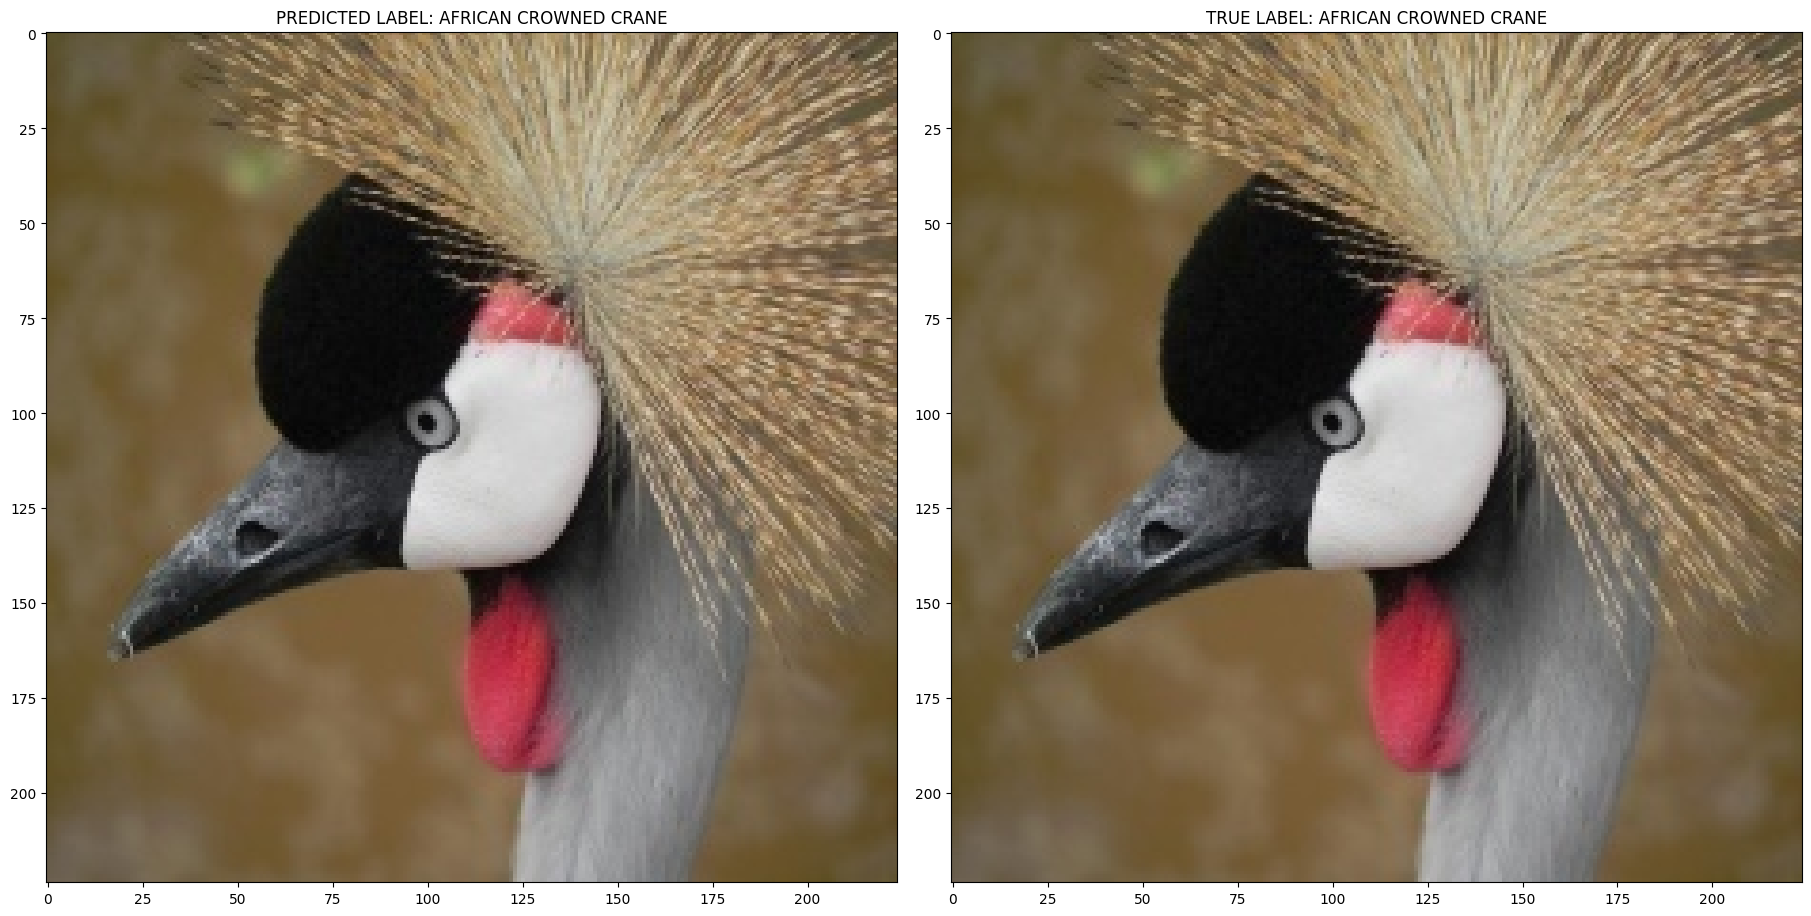

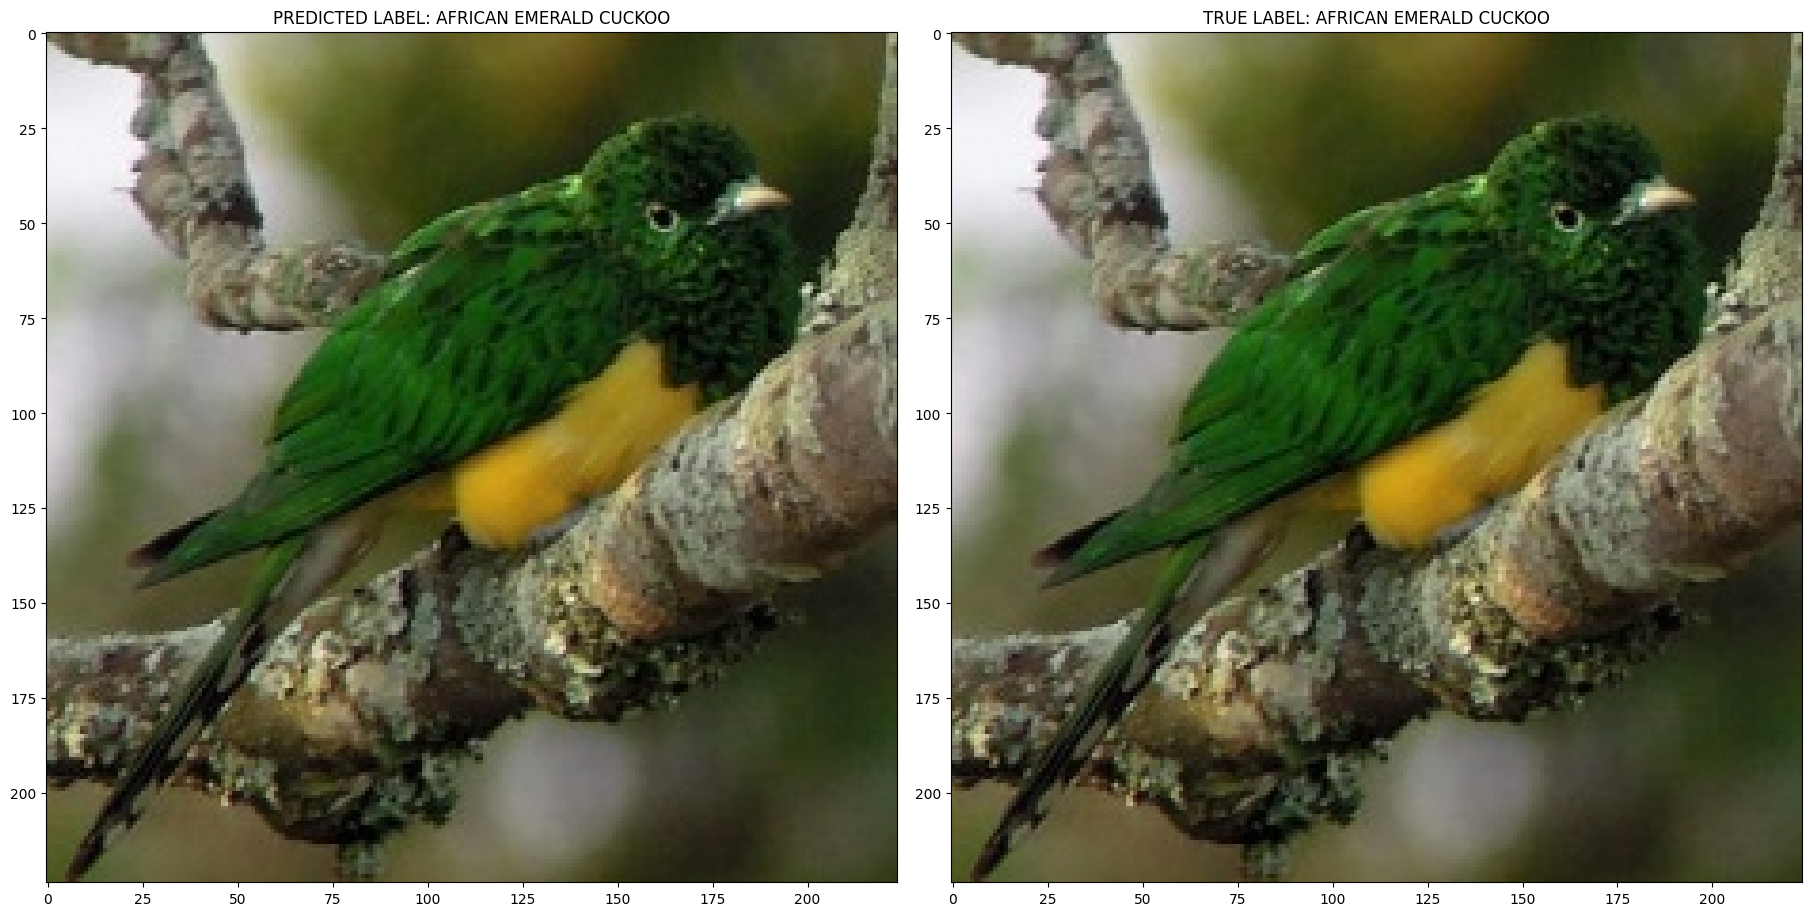

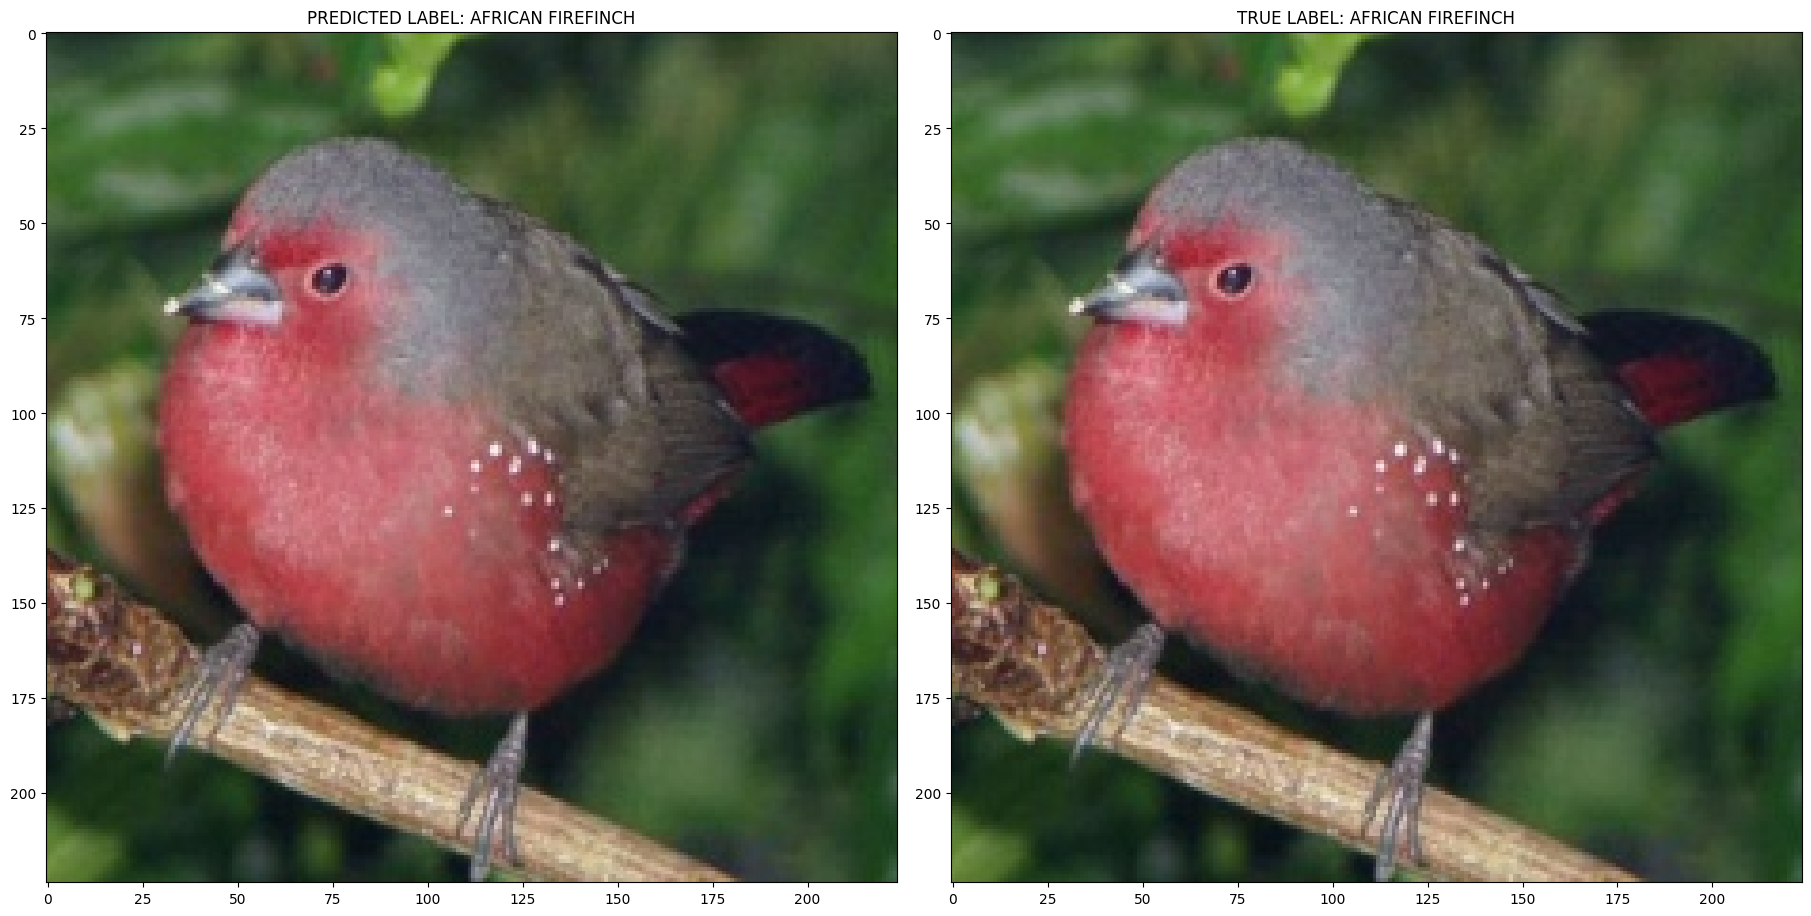

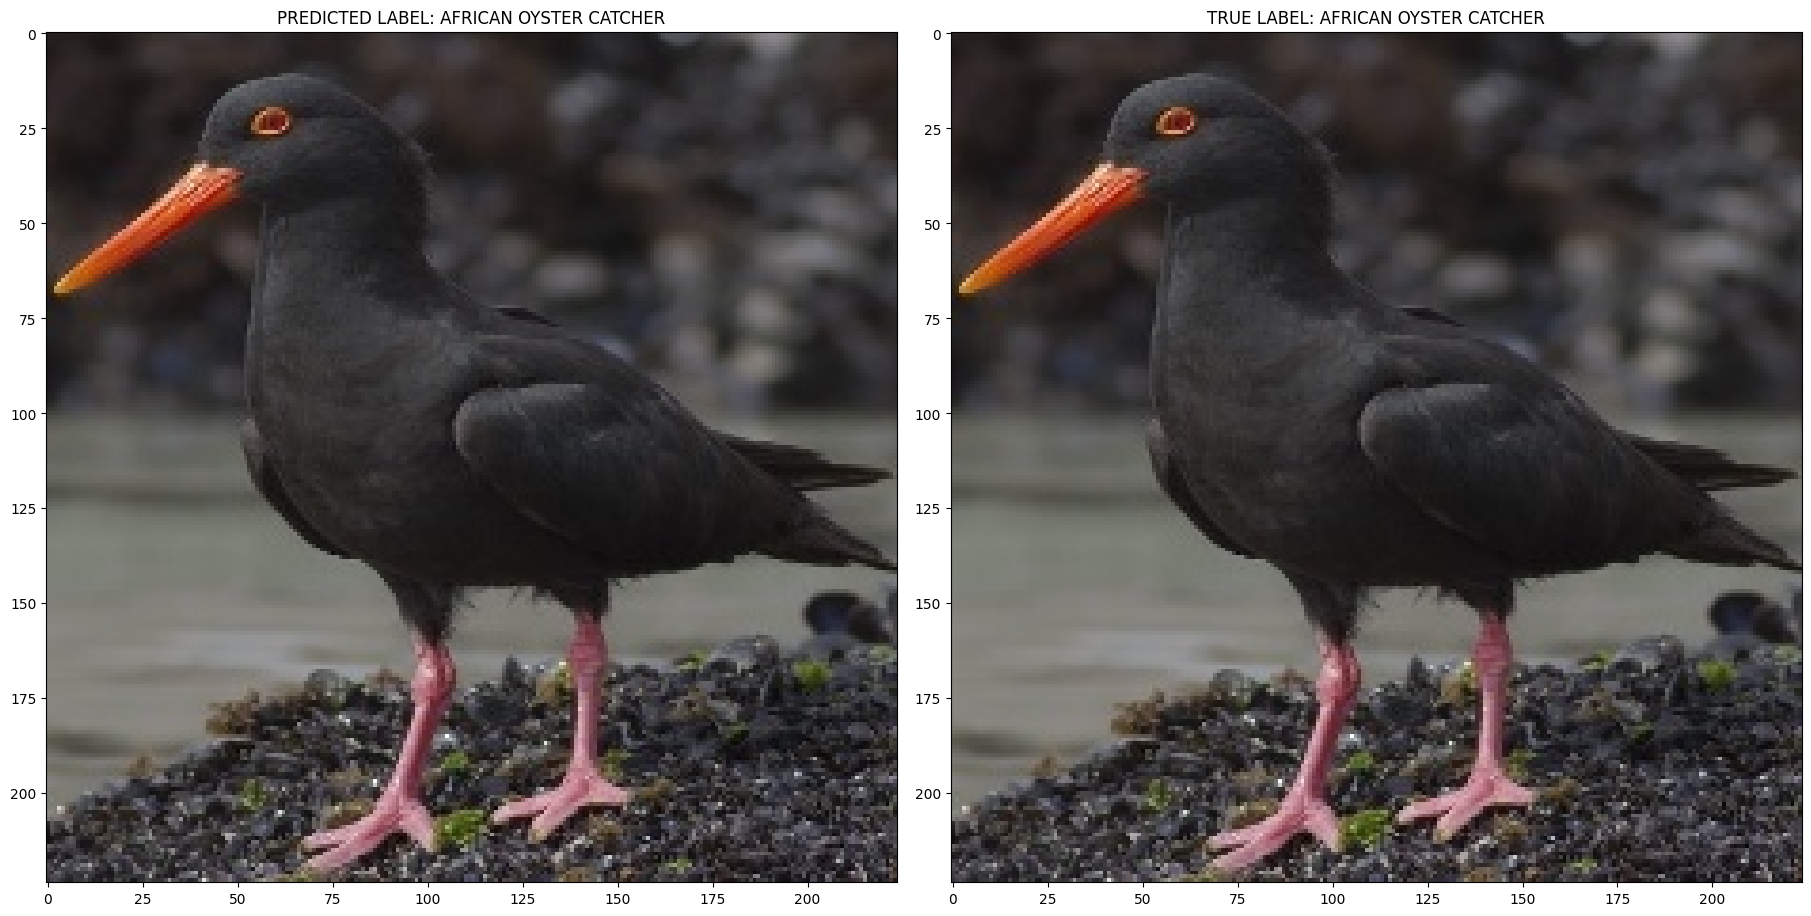

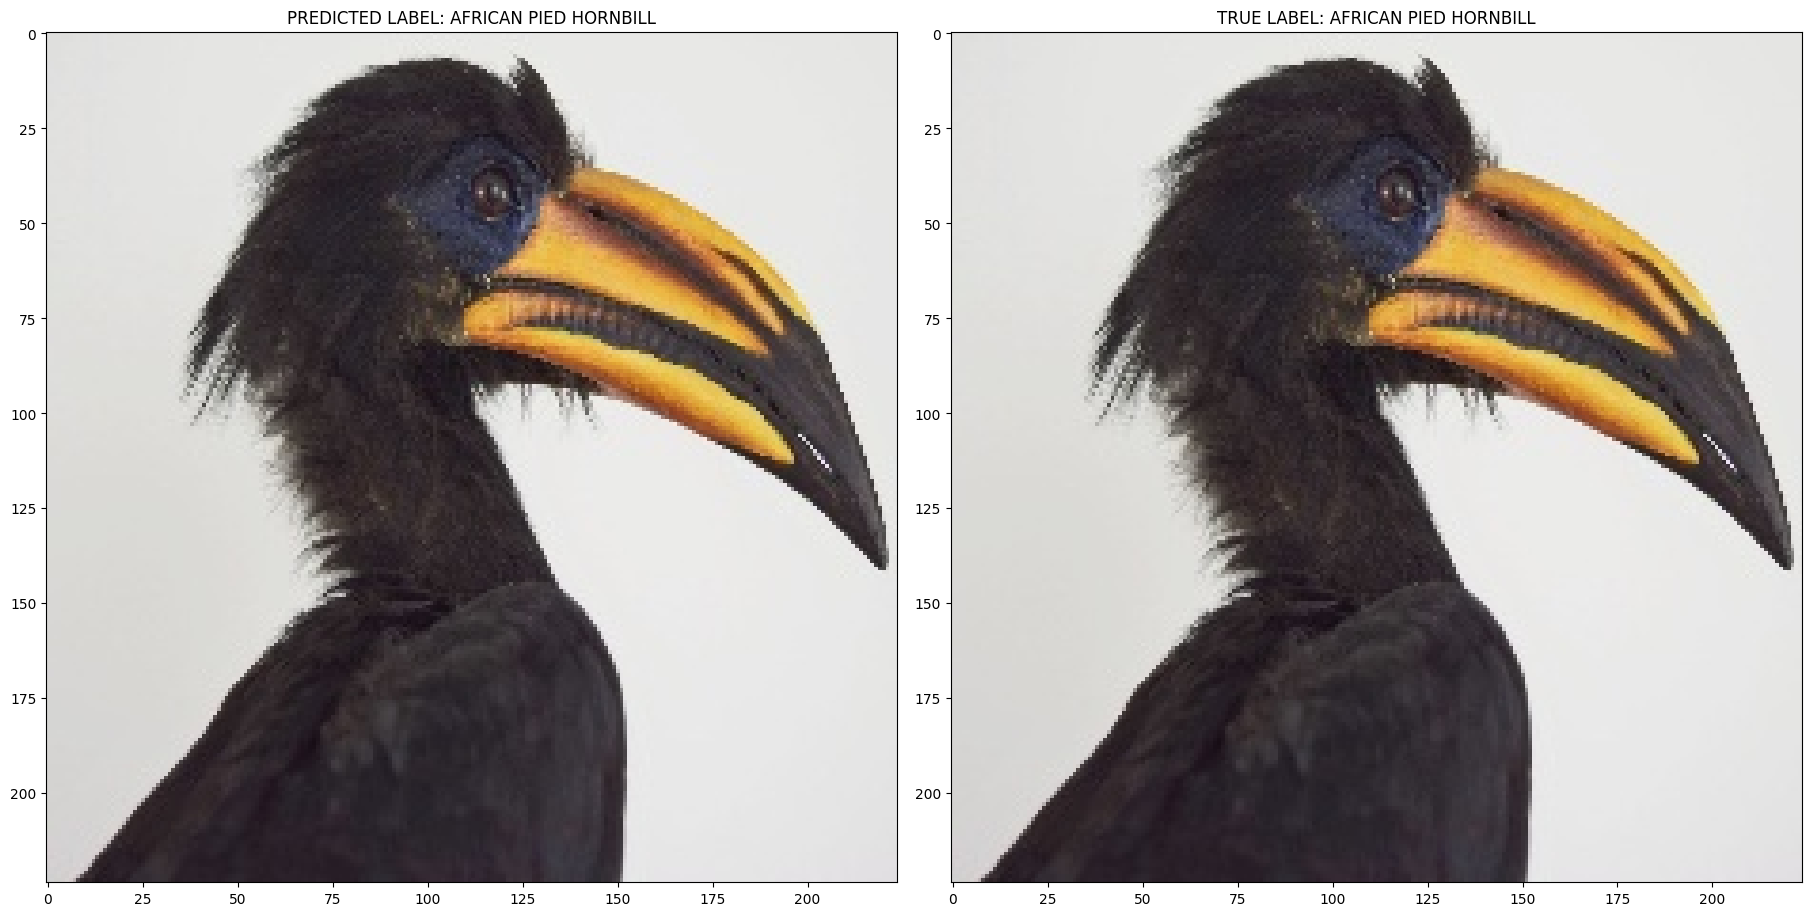

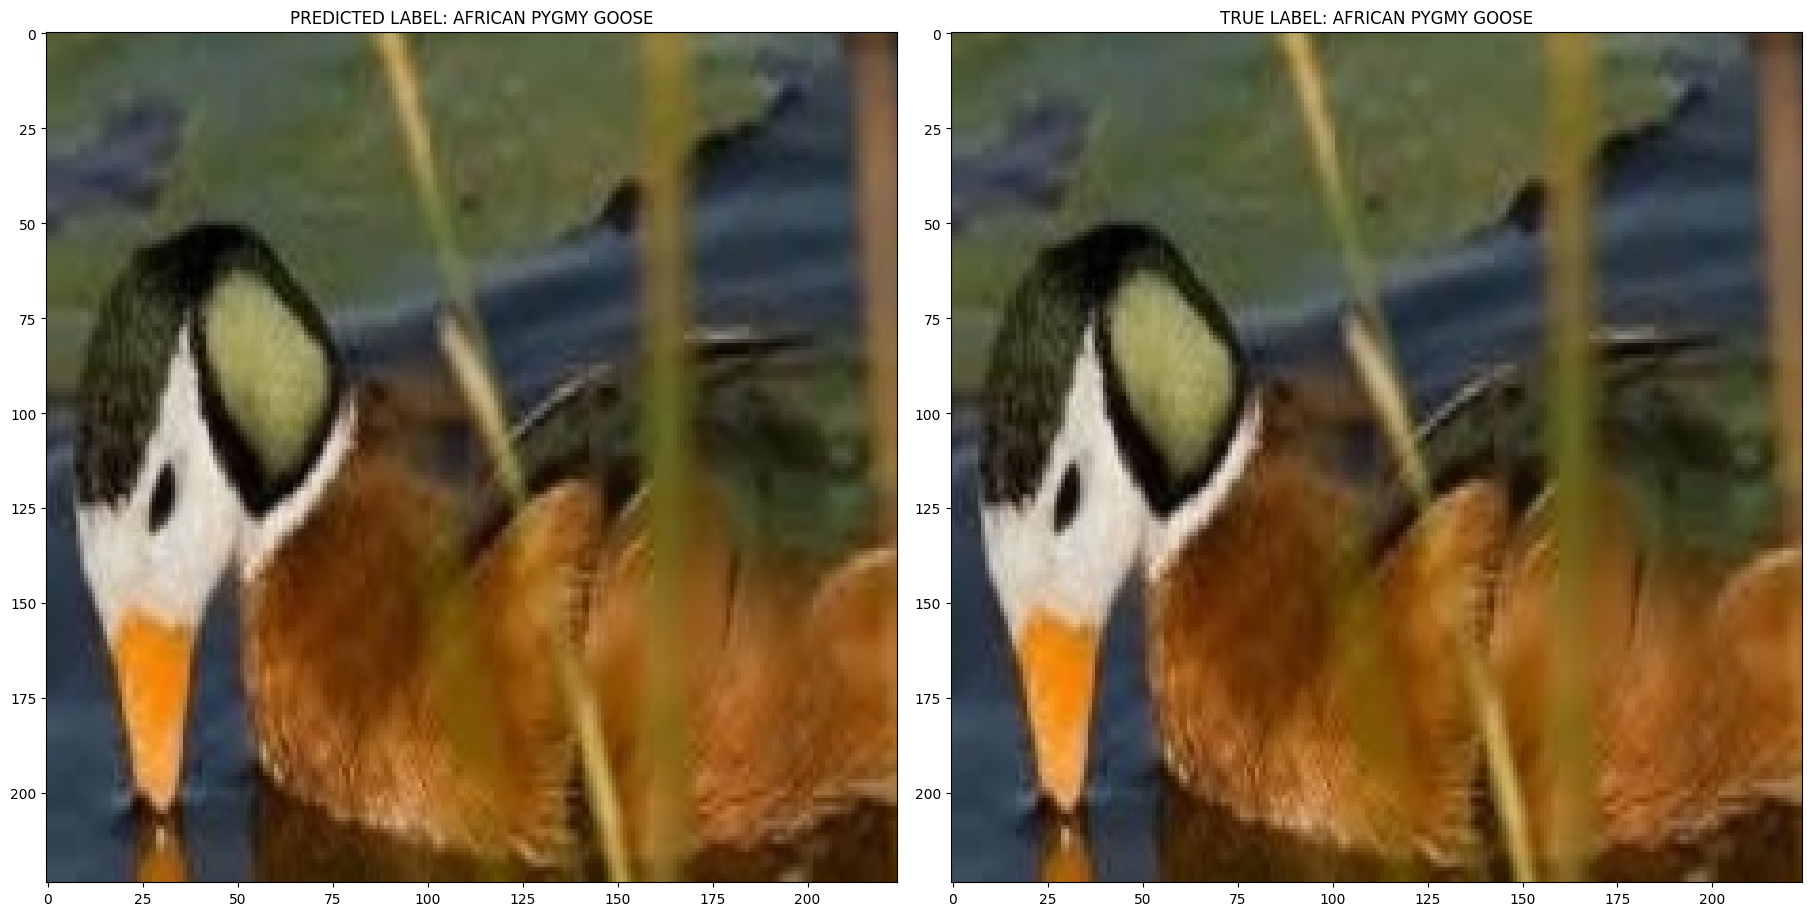

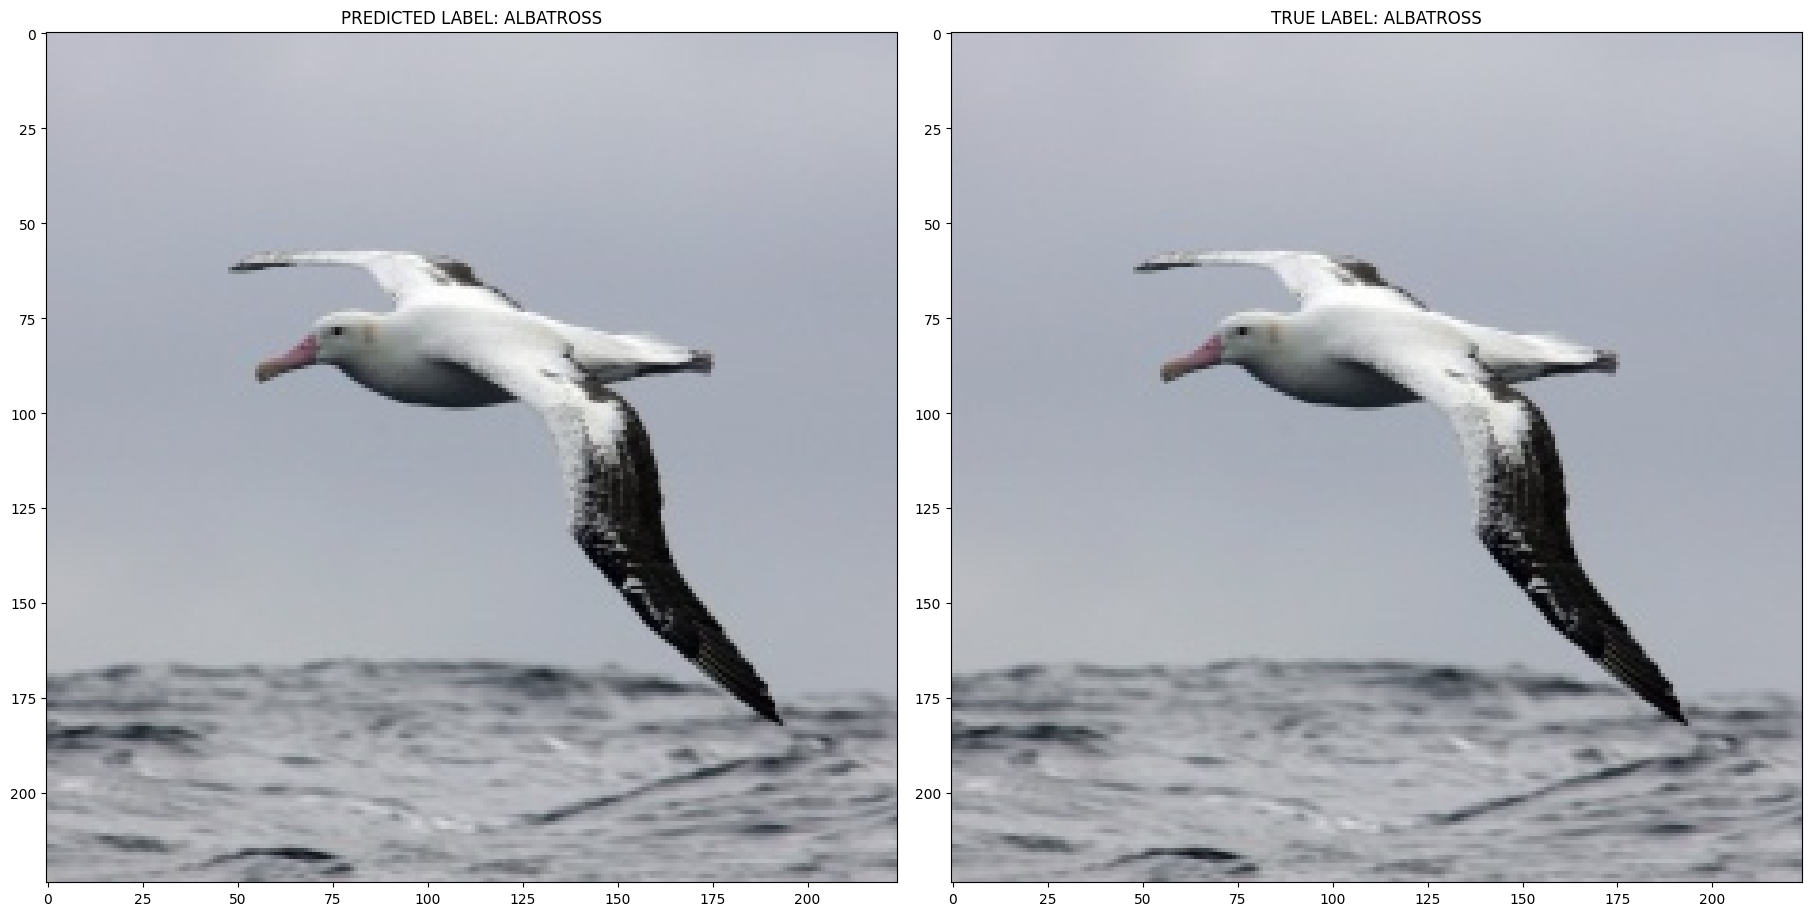

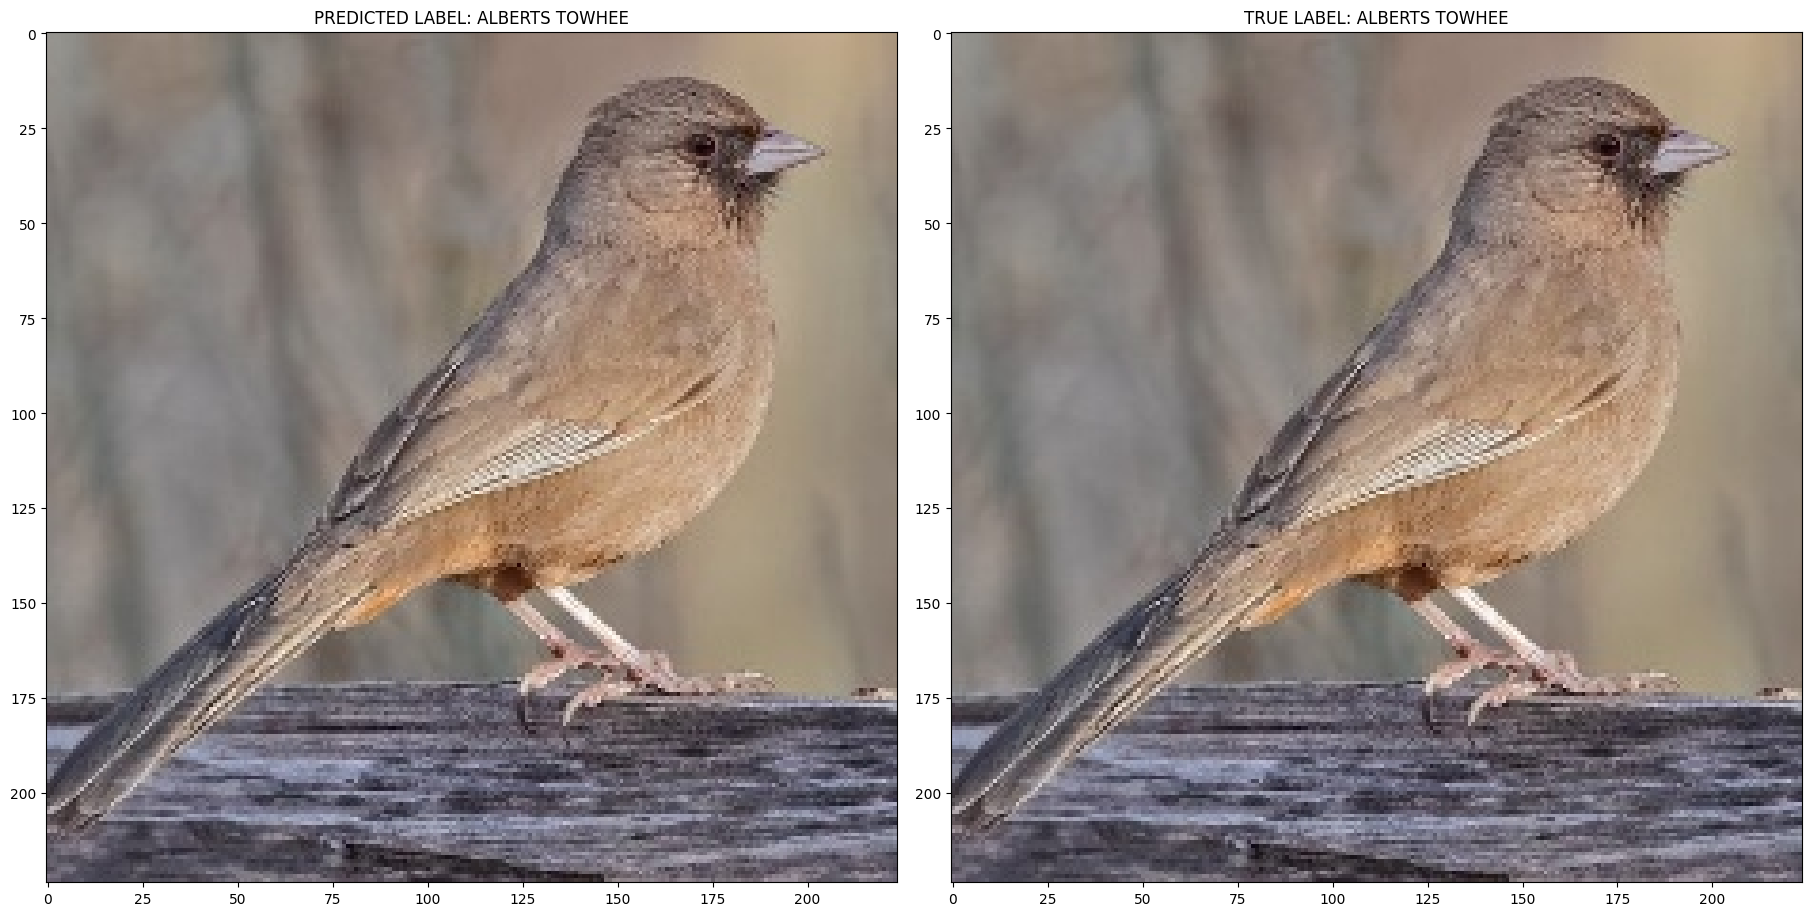

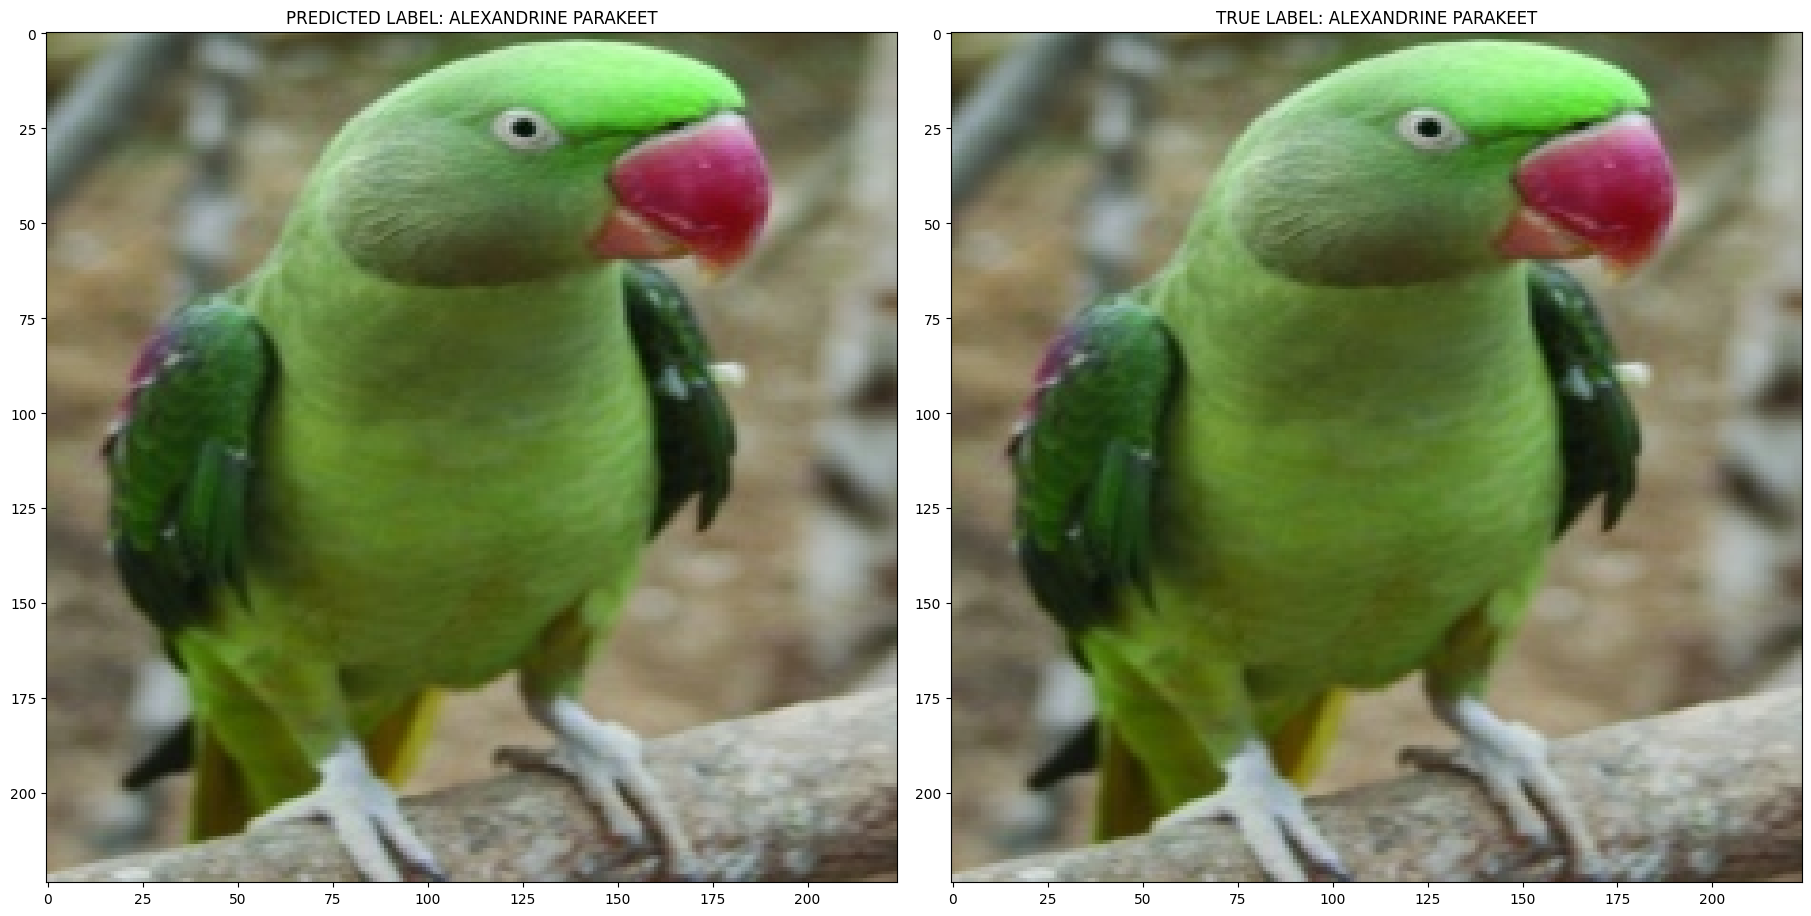

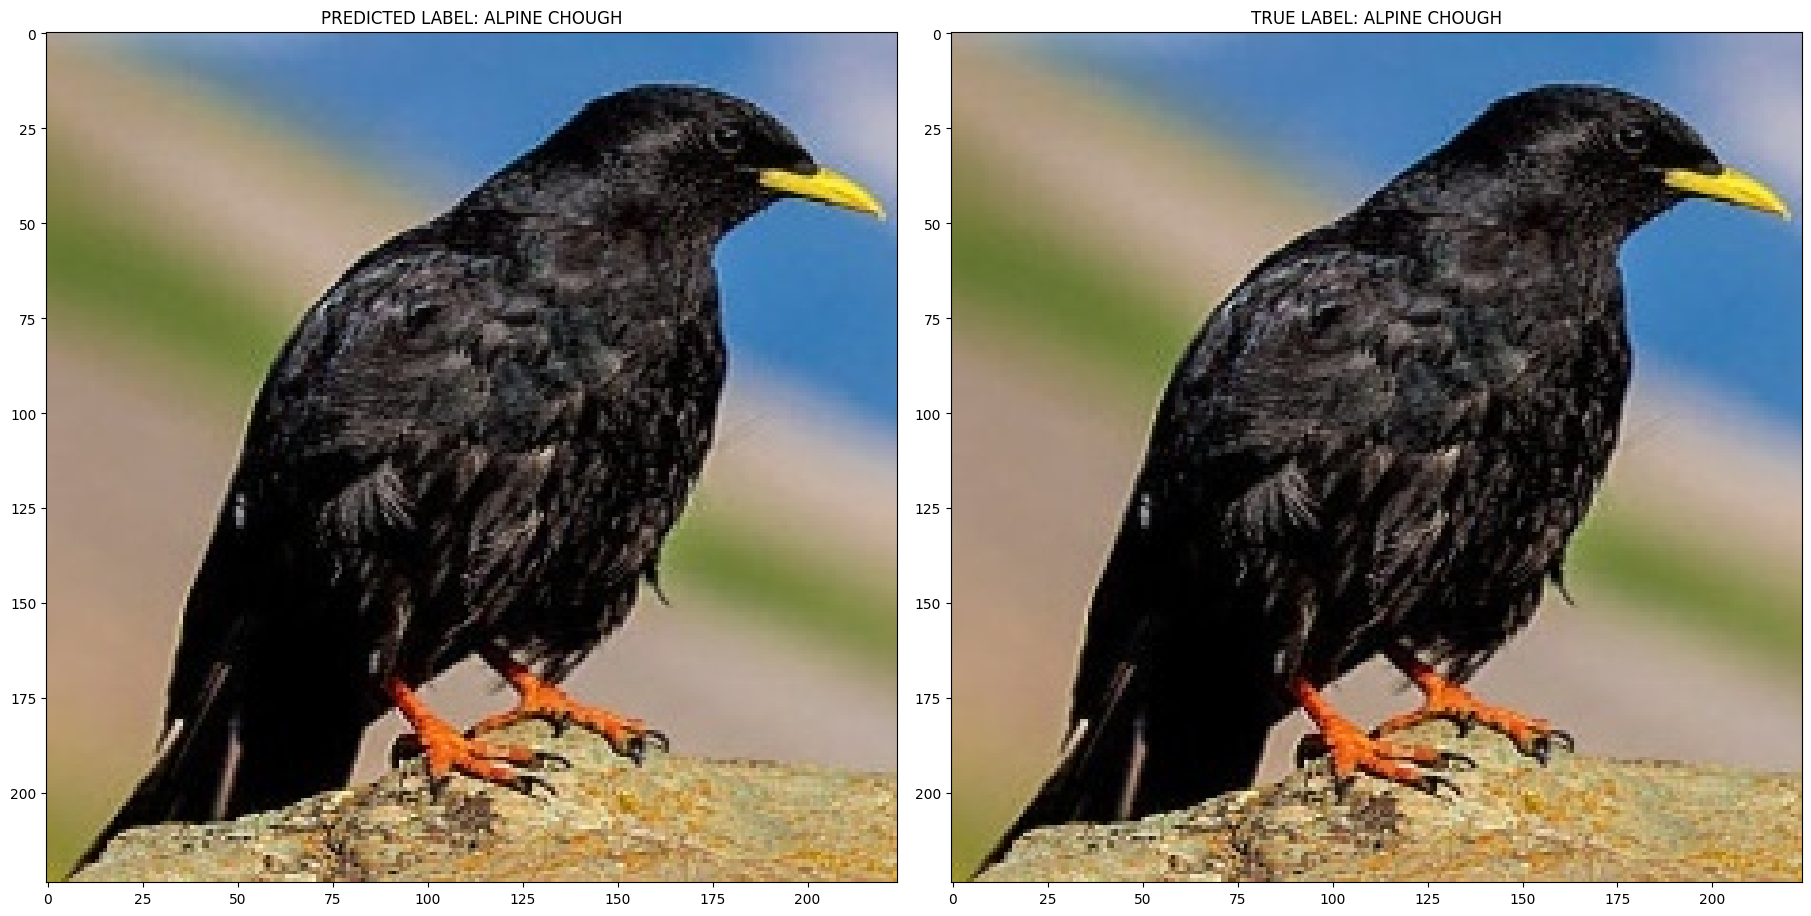

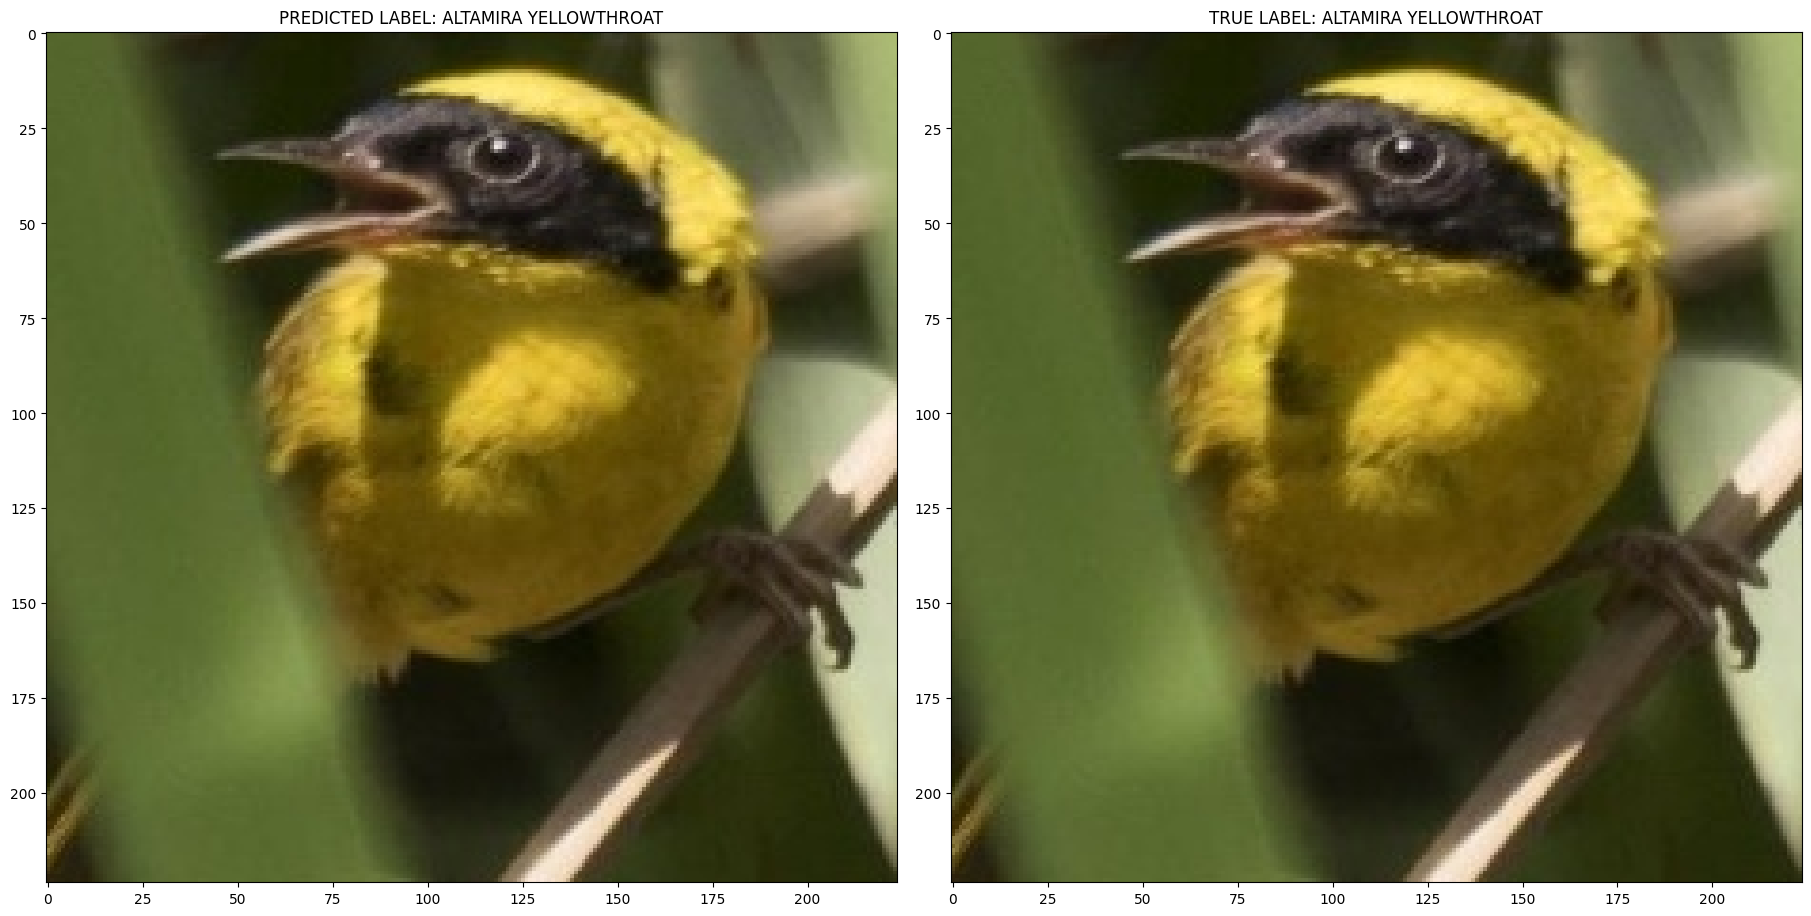

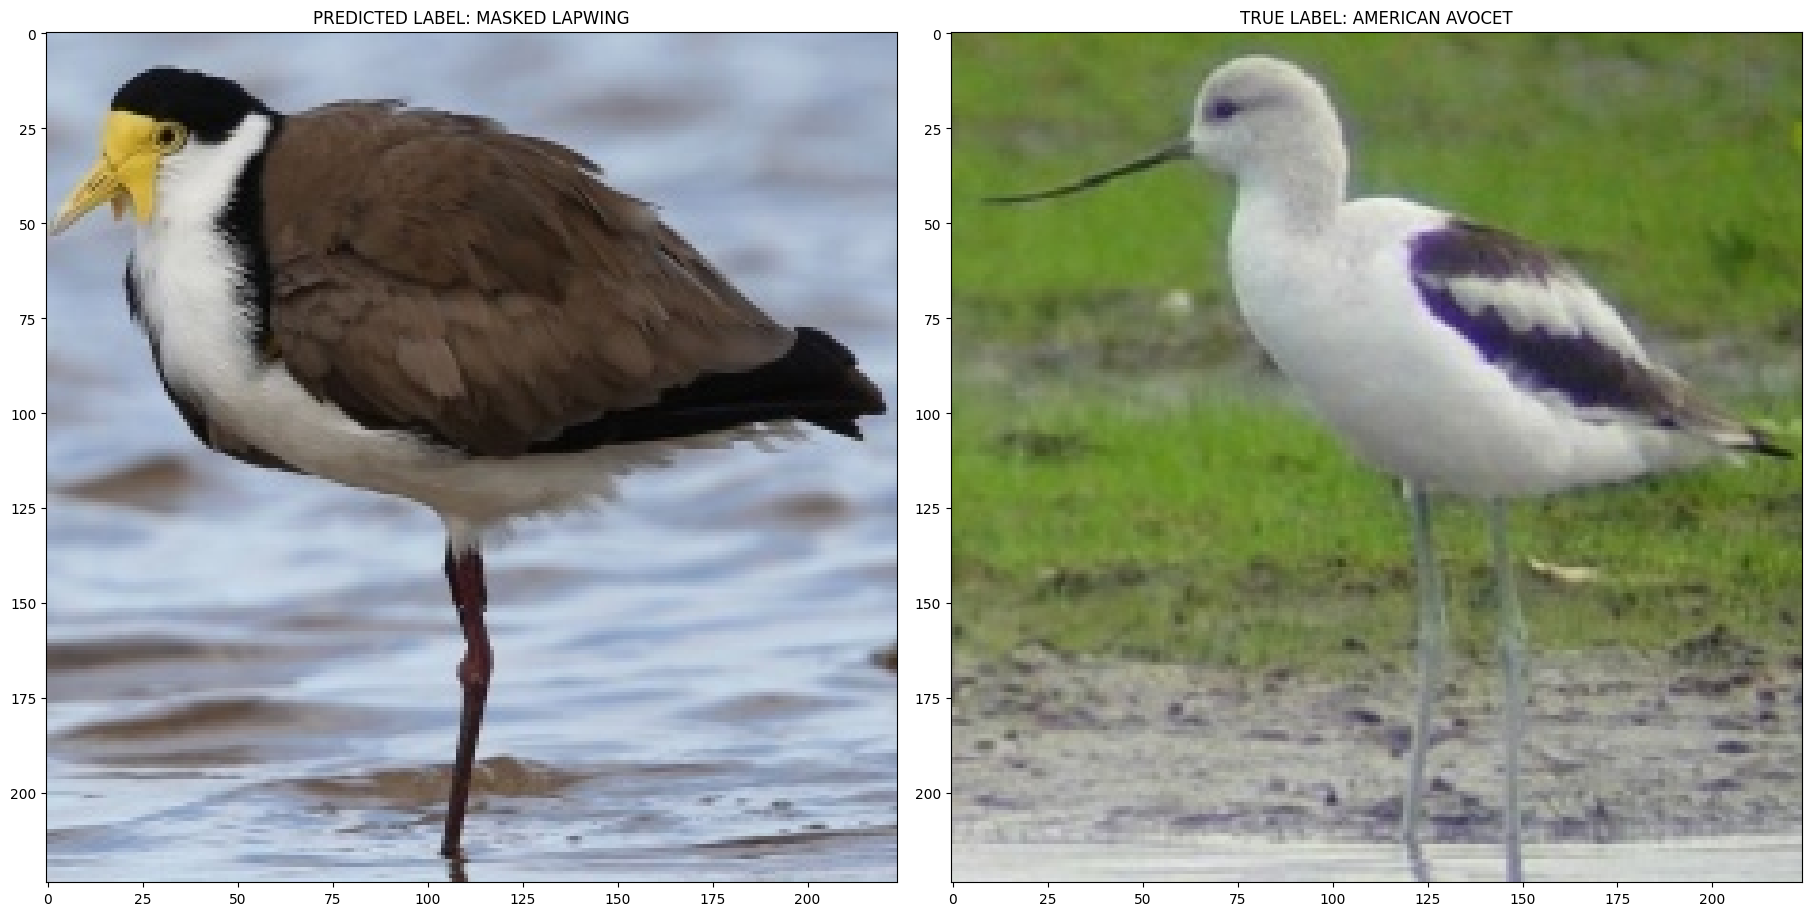

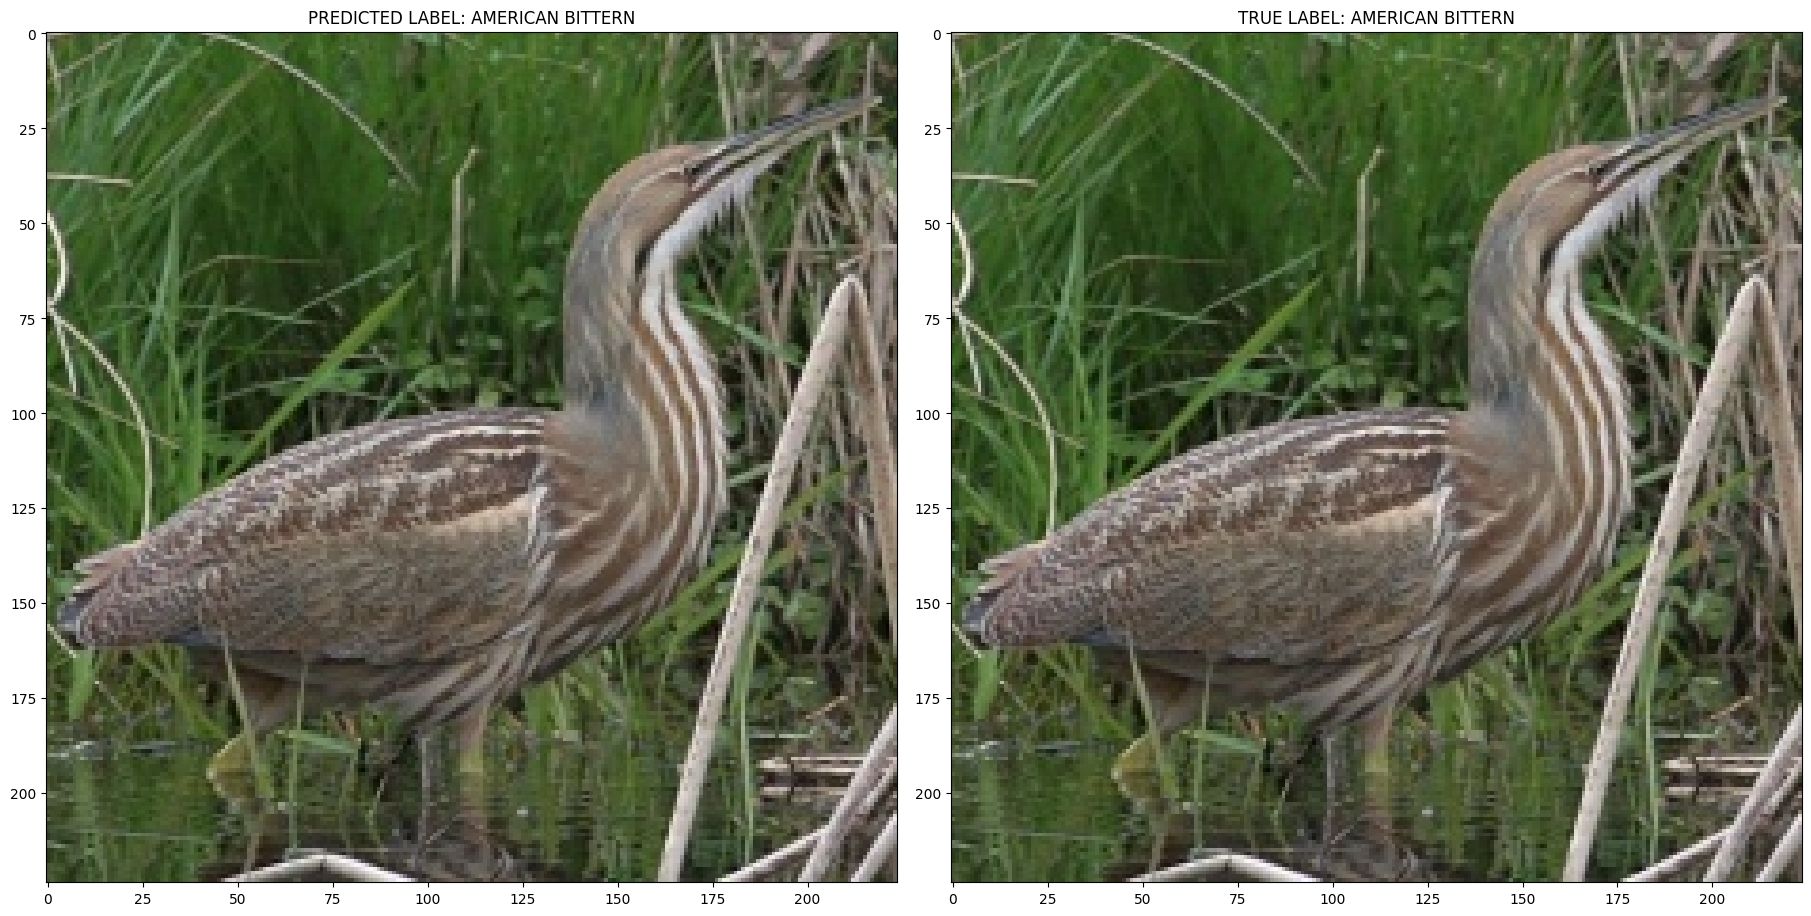

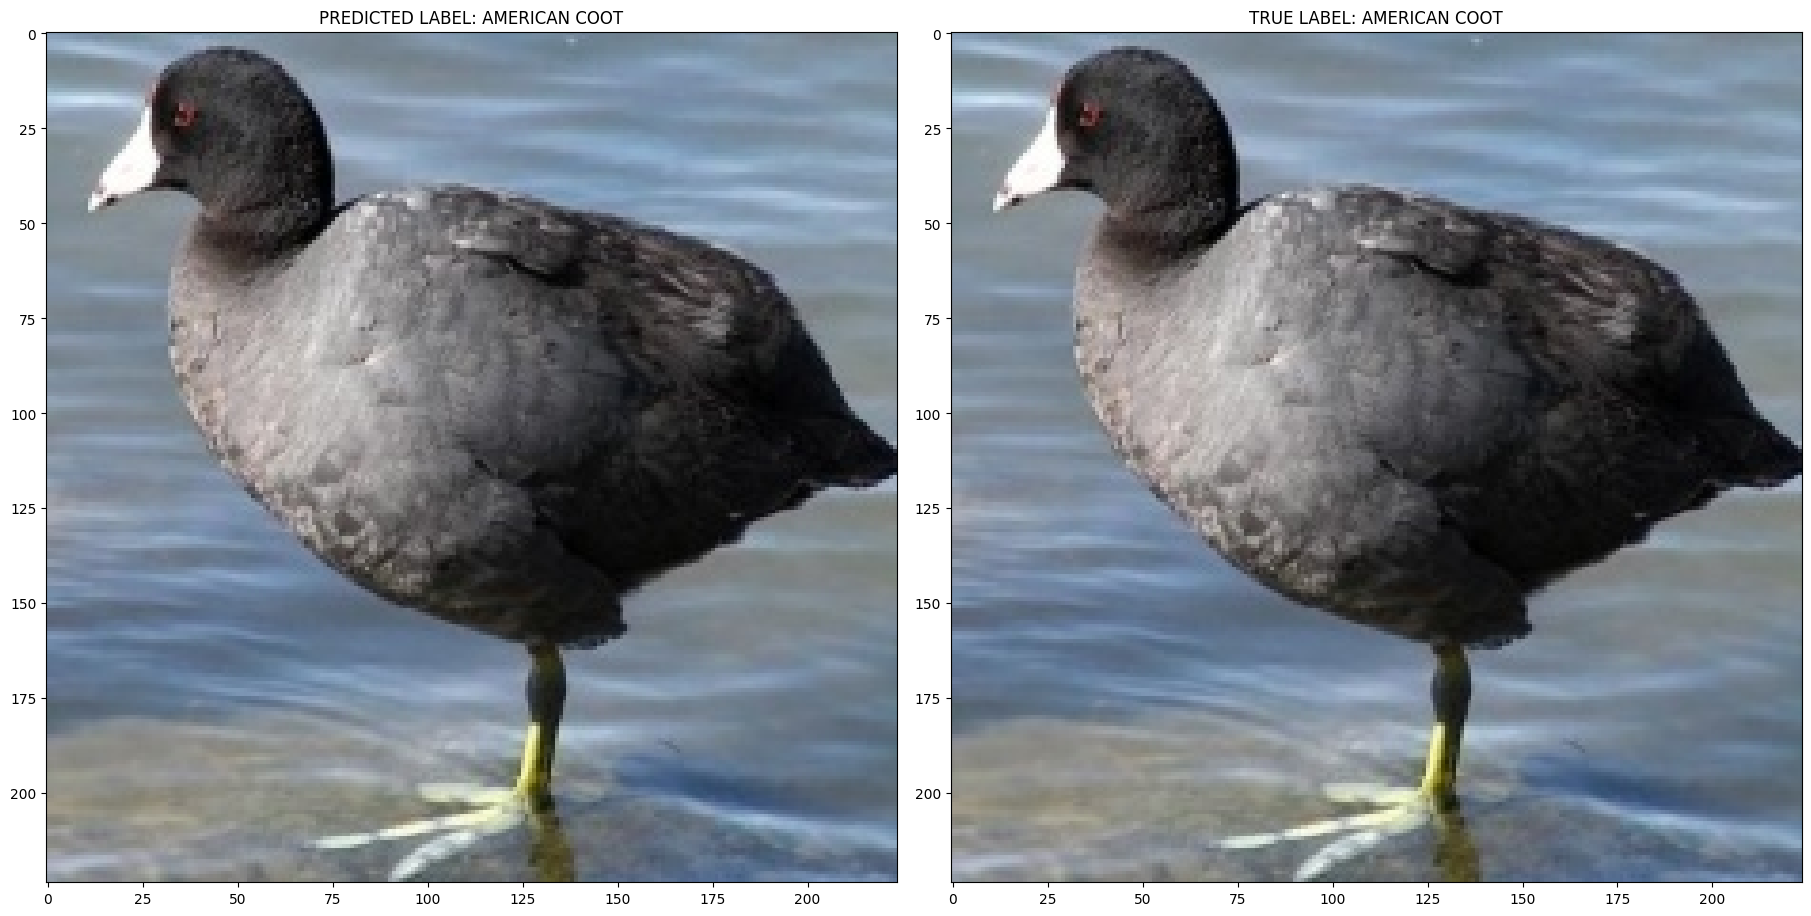

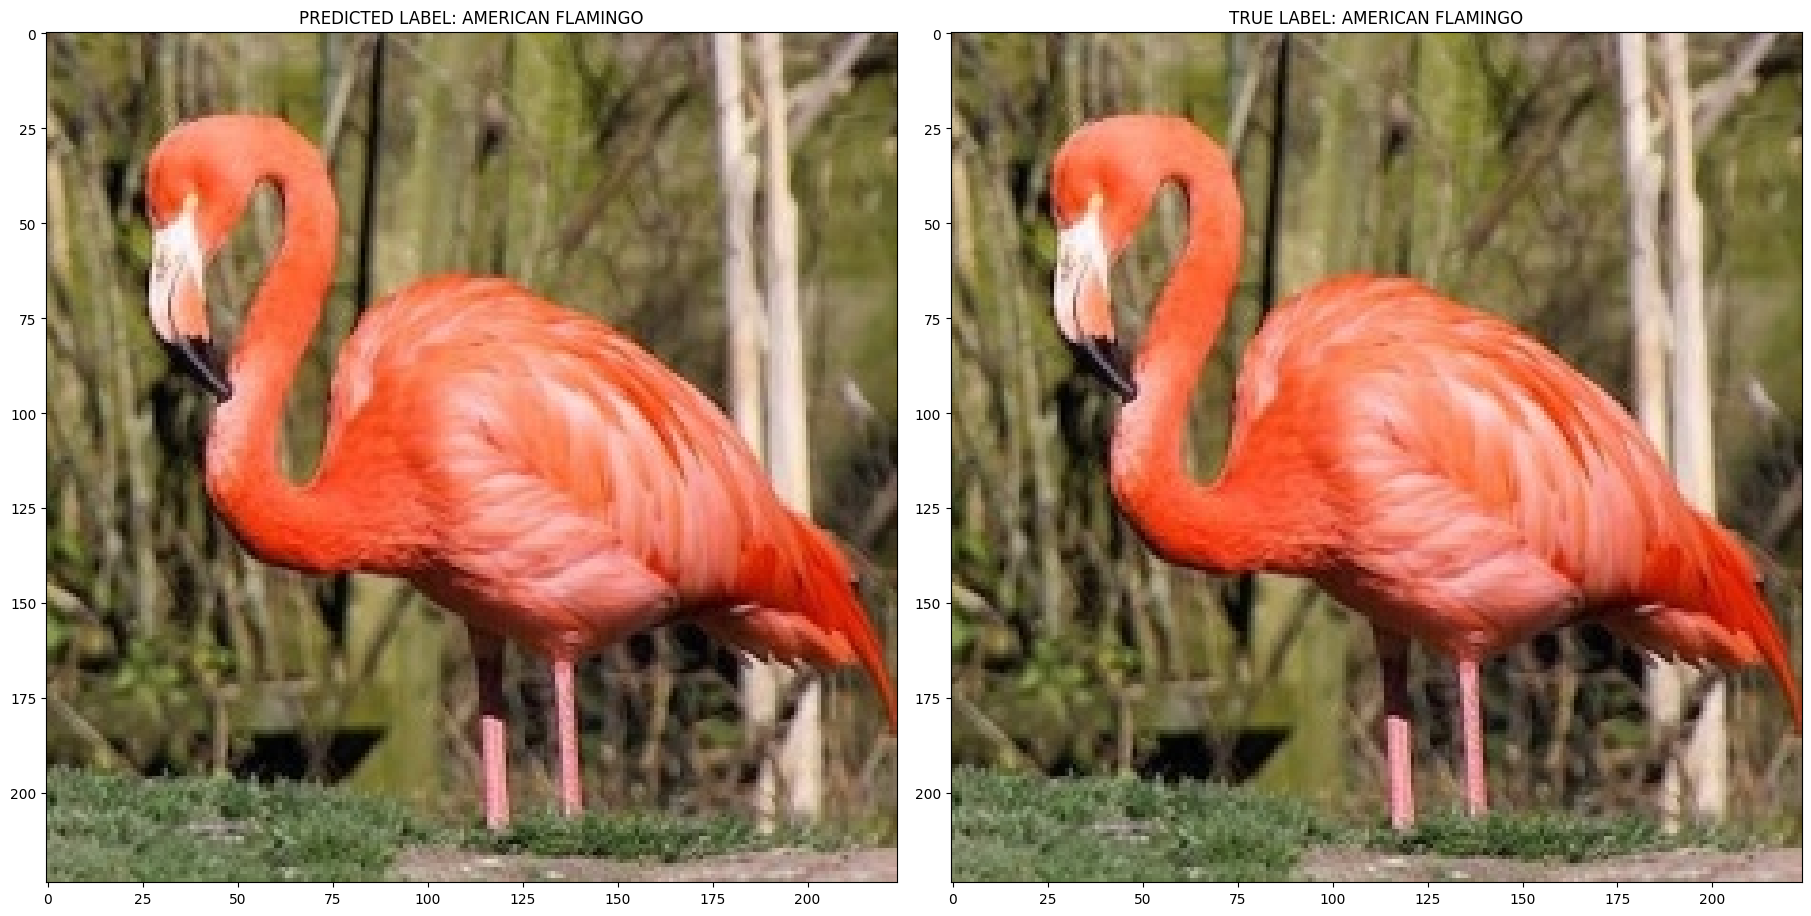

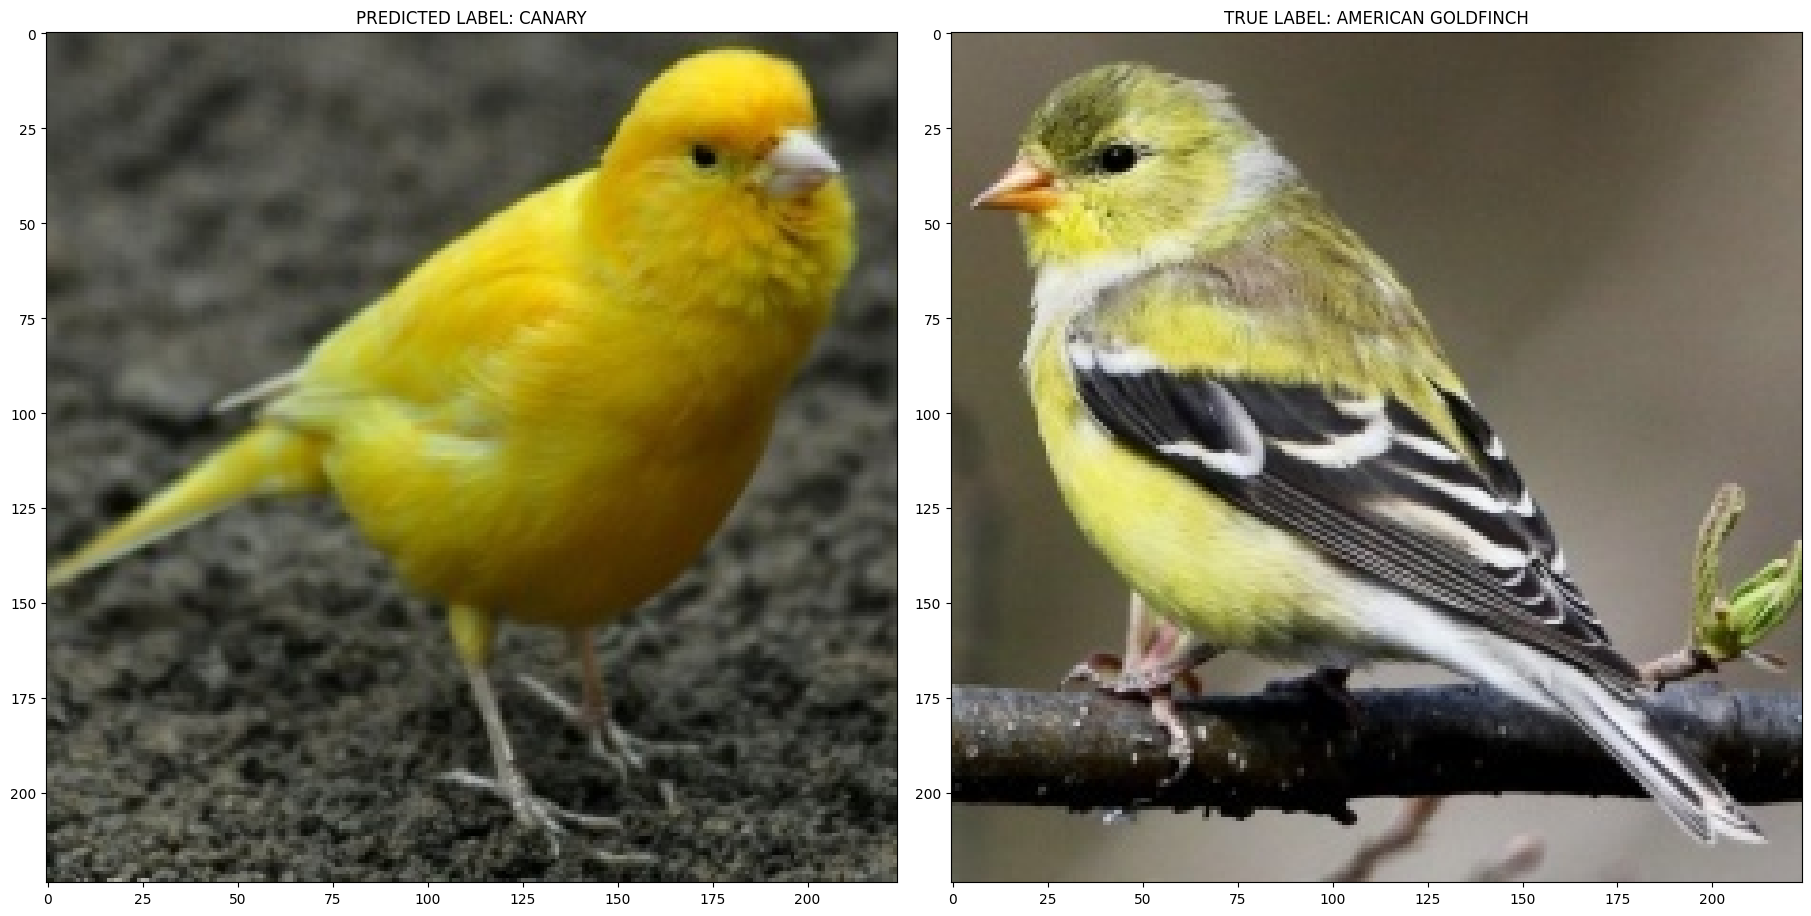

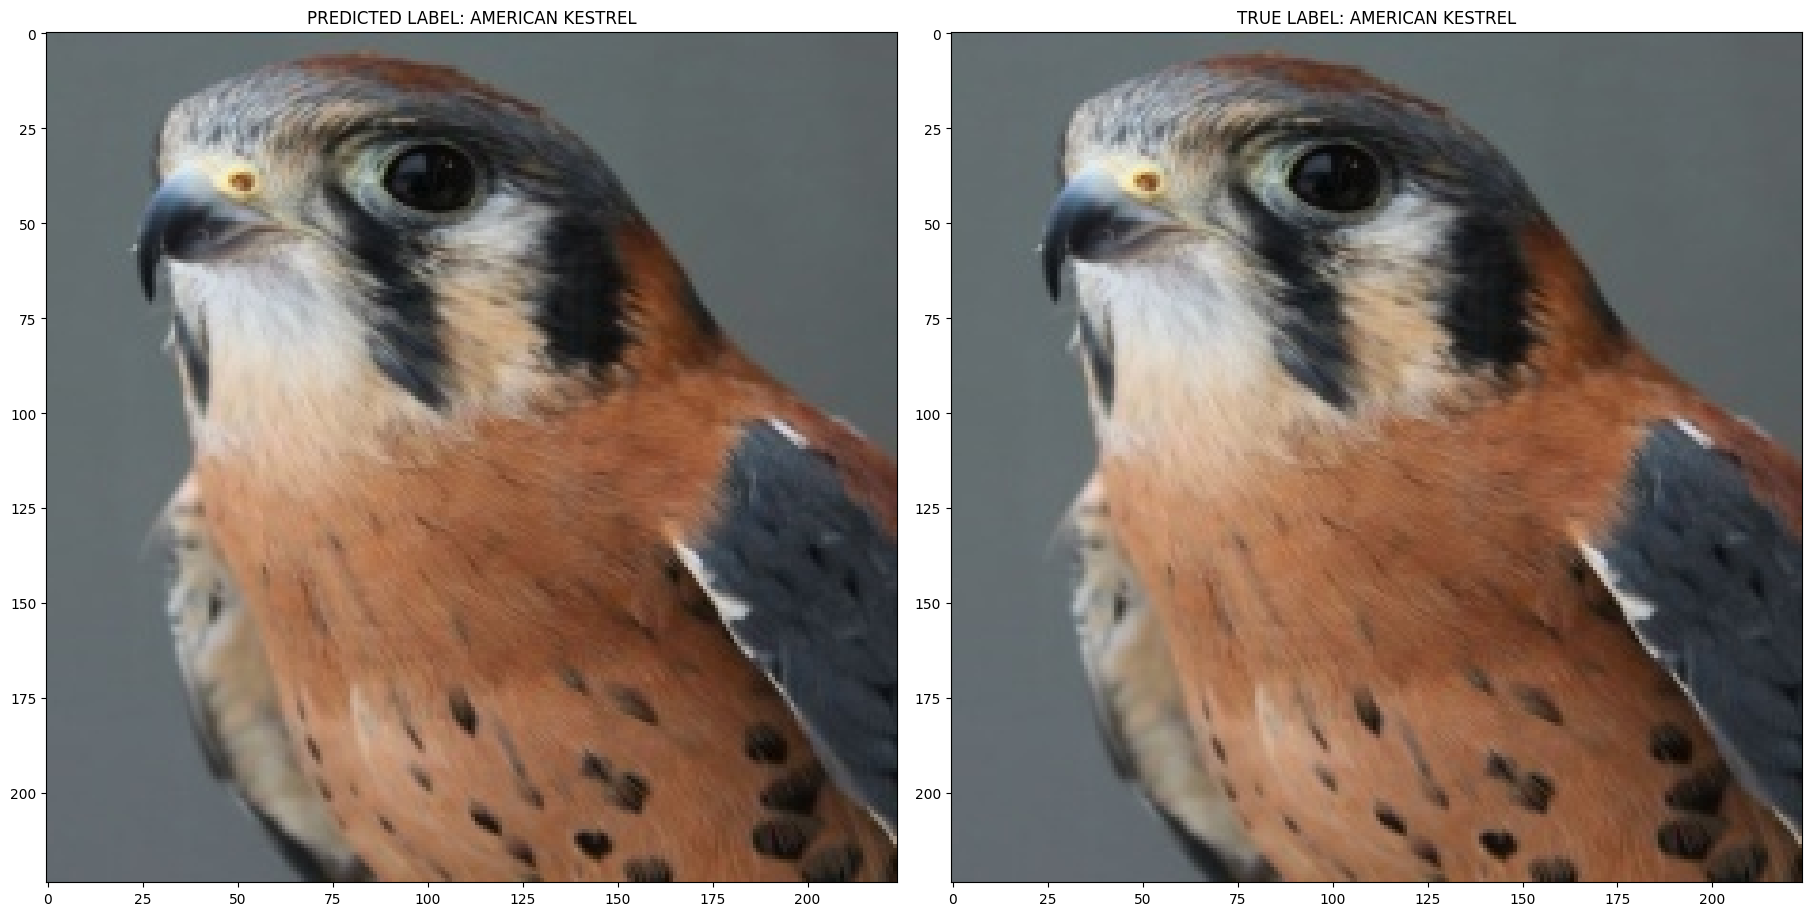

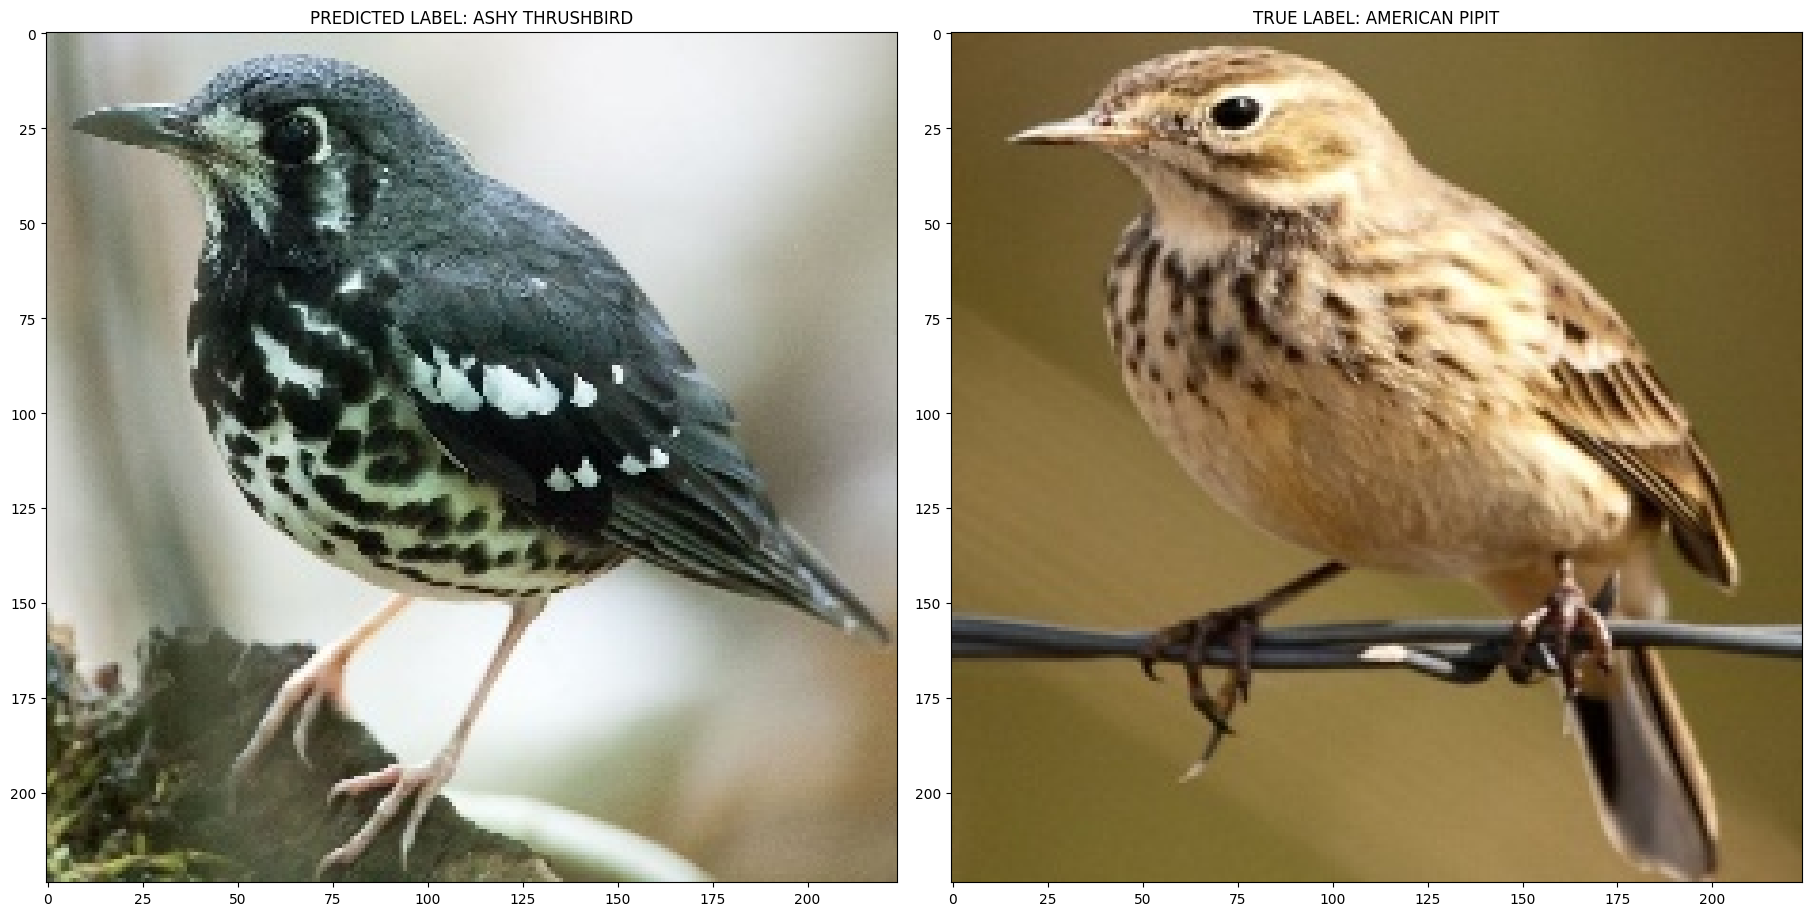

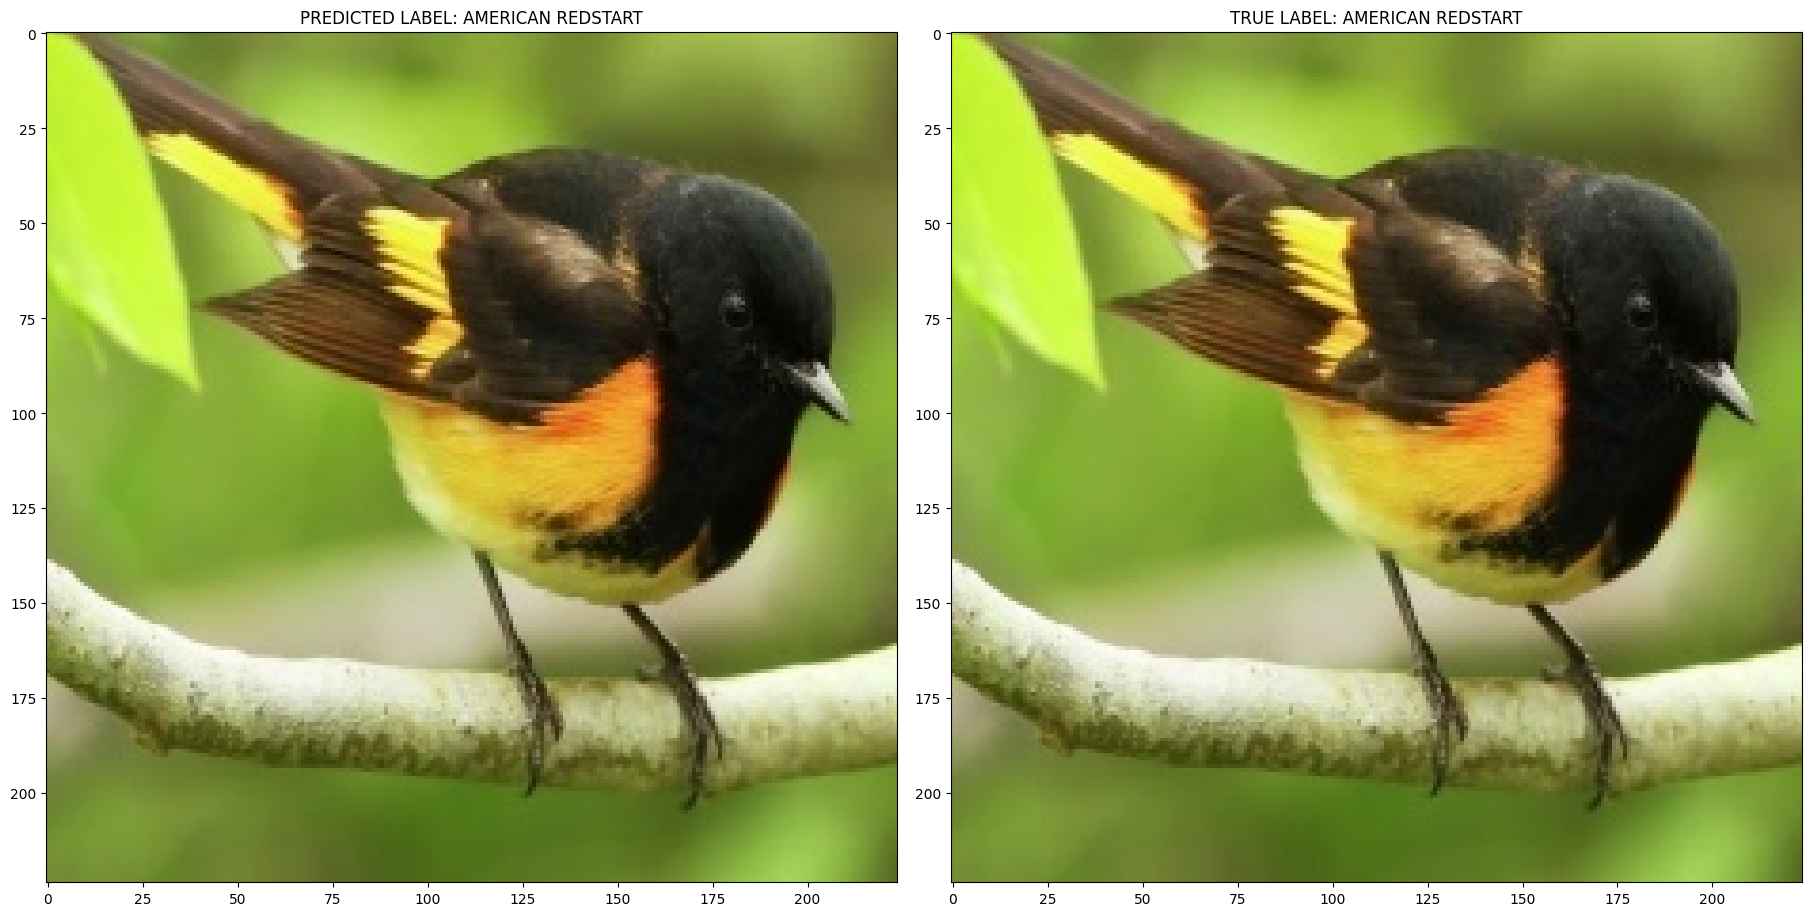

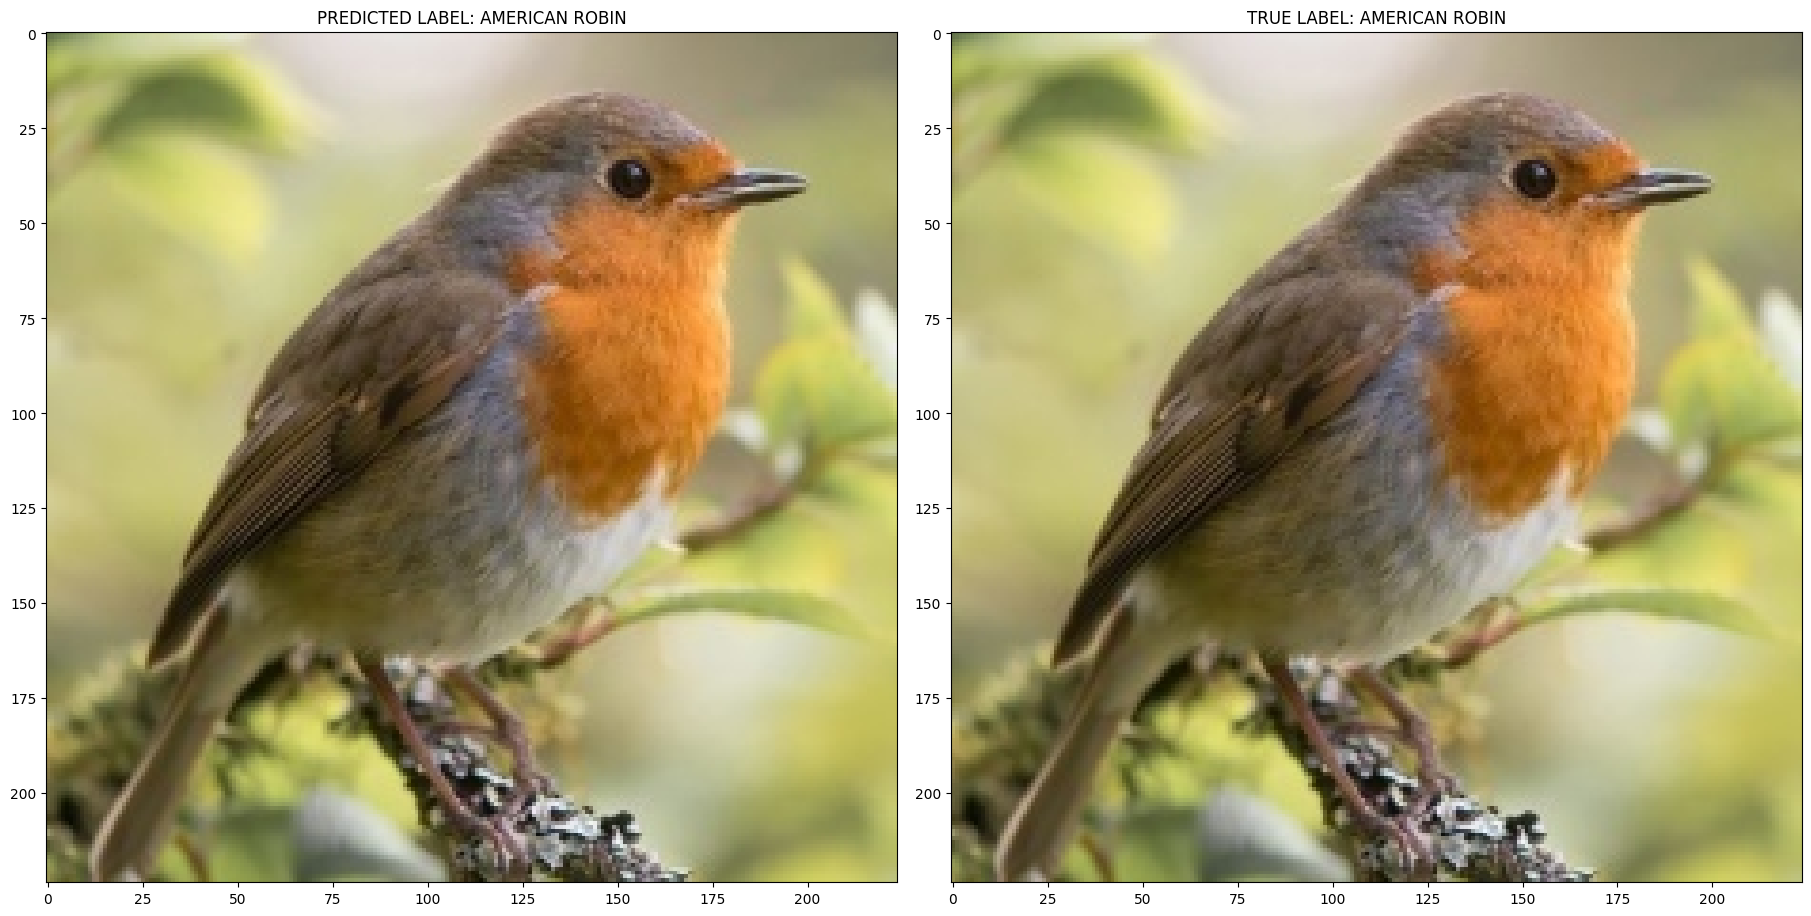

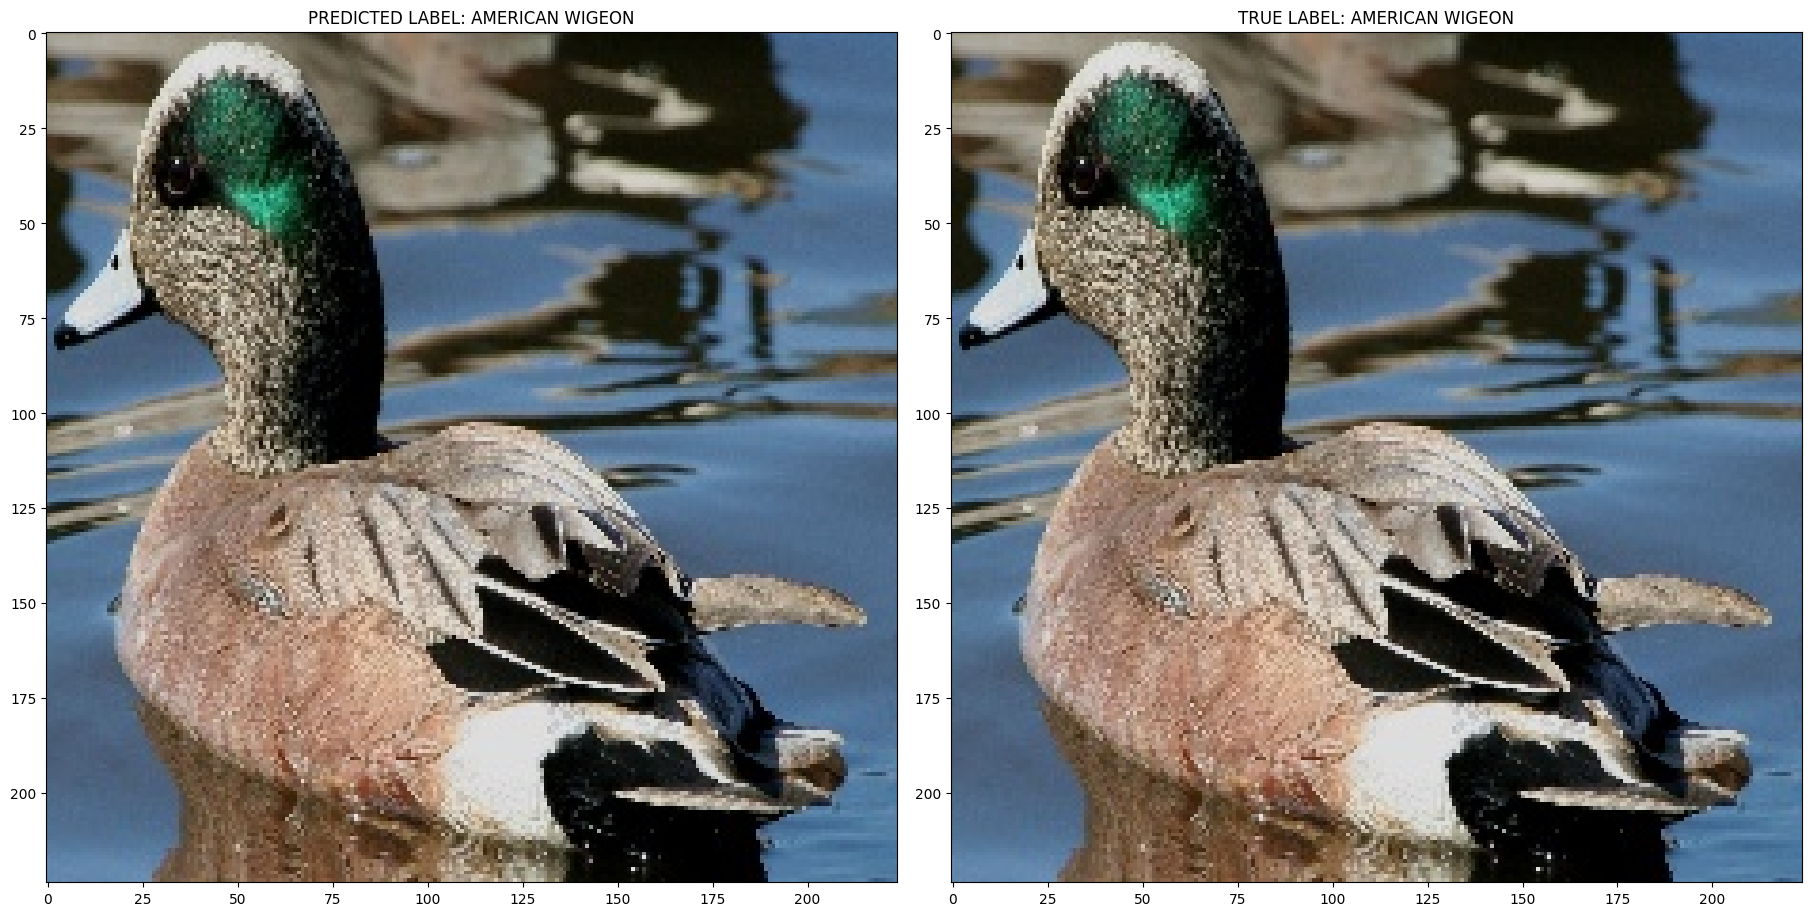

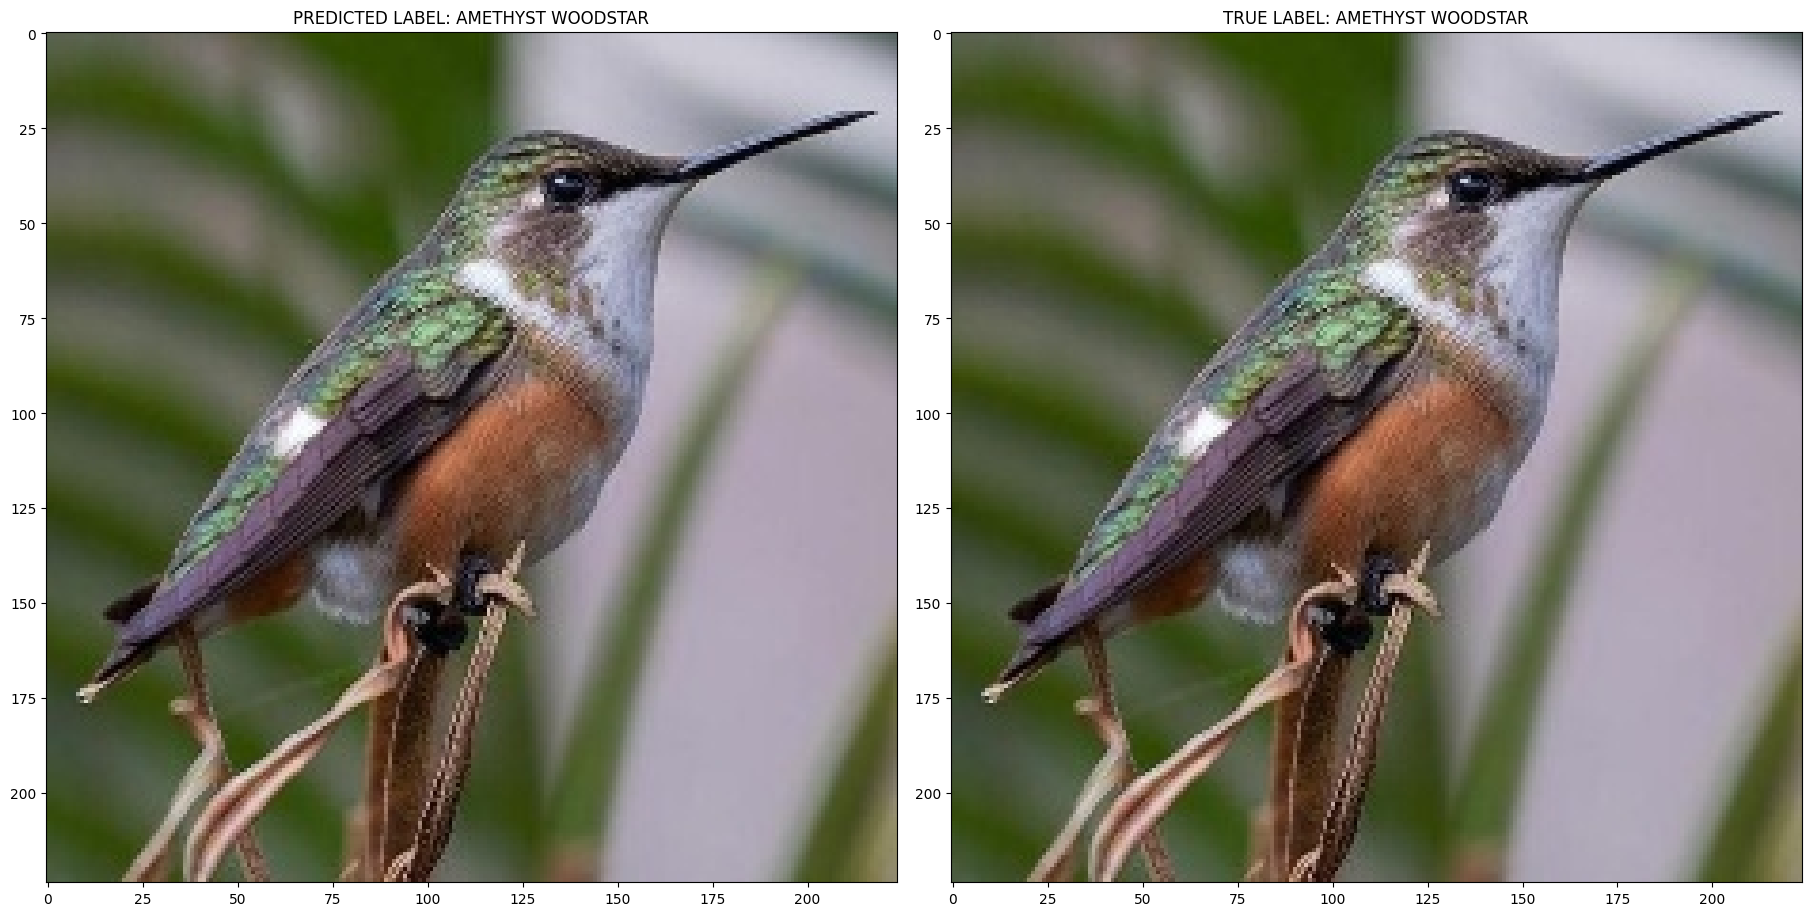

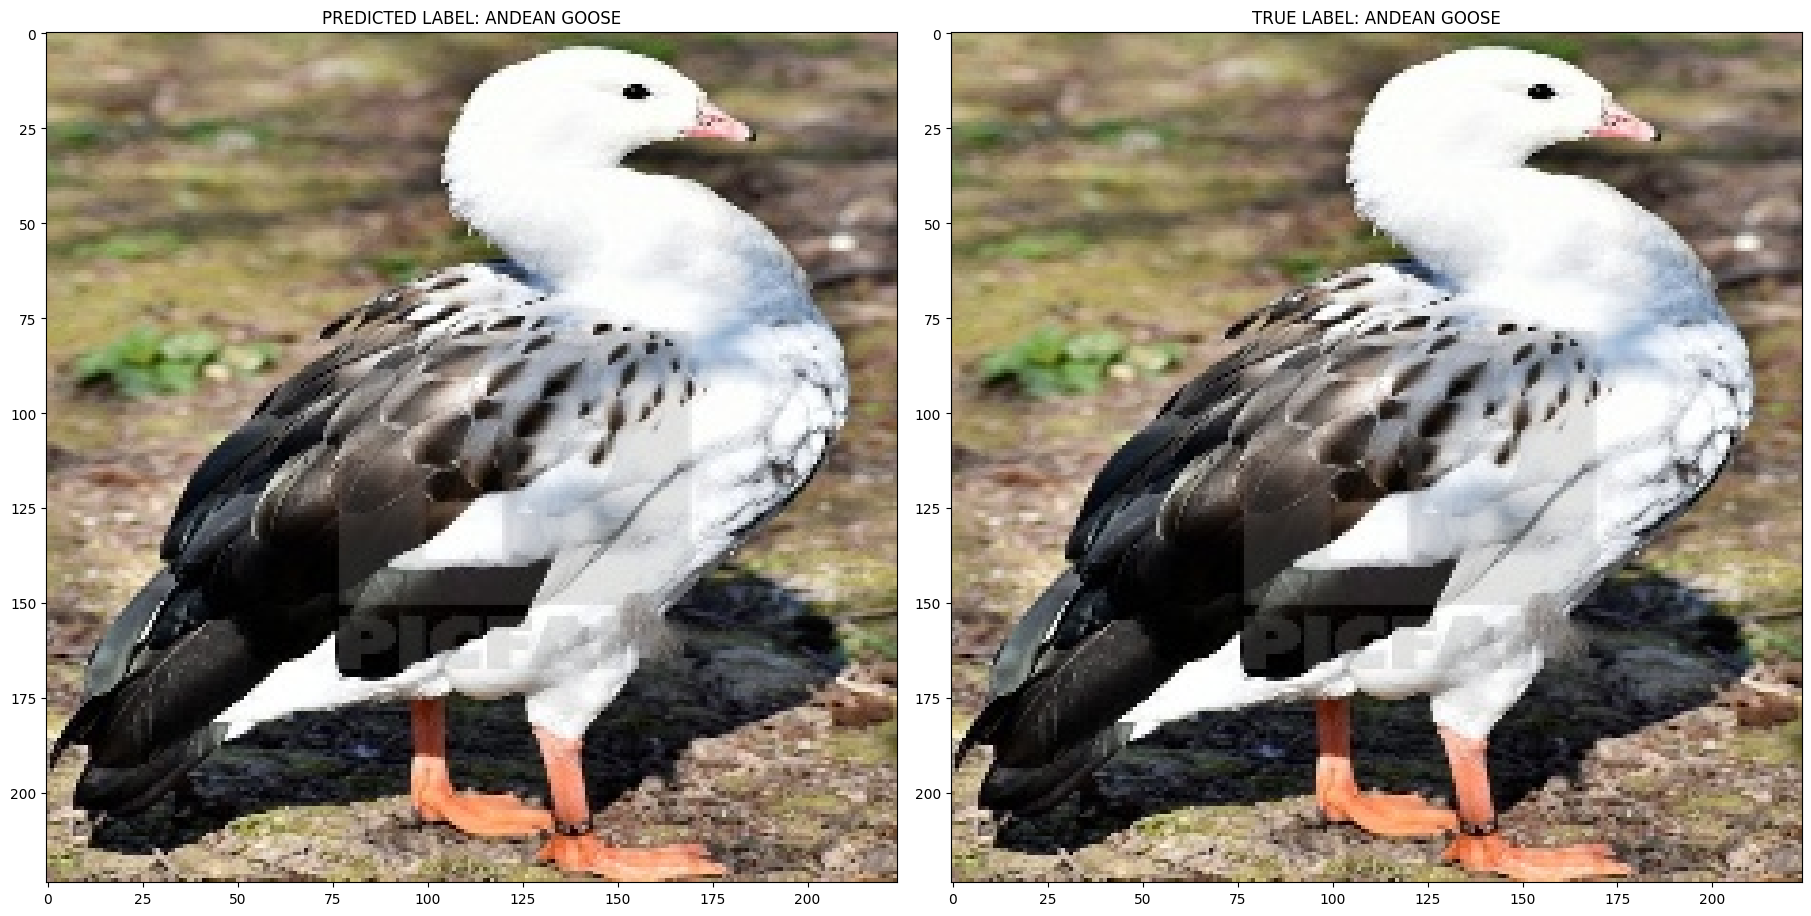

In [18]:
for idx, (predicted_bird, actual_bird) in enumerate(zip(predicted_birds, actual_birds)):
    if idx % 5 == 0:
        tensor_to_pil = transforms.ToPILImage()
        fig, axes = plt.subplots(1,2, figsize = (18,18), constrained_layout = True)
        pred_image = tensor_to_pil(test_image.__get_image_from_species__(predicted_bird))
        true_image = tensor_to_pil(test_image.__get_image_from_species__(actual_bird))

        axes[0].imshow(pred_image)
        axes[0].set_title(f'PREDICTED LABEL: {predicted_bird}')
        axes[1].imshow(true_image)
        axes[1].set_title(f'TRUE LABEL: {actual_bird}')
        plt.show()
    